# Lietuvos Elektros Rinkos Analizė ir Optimizavimas / Lithuanian Electricity Market Analysis and Optimization
**Autorius / Author:** Aurimas A. Nausėdas

**Data / Date:** 2025-06-29

Šis notebook'as analizuoja 2024 m. Lietuvos elektros sistemos duomenis, kuria spekuliacines prekybos ir baterijų saugojimo strategijas bei vertina vartotojų reakciją į kainą. Analizė atlikta pagal uzduotis.pdf struktūrą.

This notebook analyzes 2024 Lithuanian electricity system data, develops speculative trading and battery storage strategies, and estimates consumer price elasticity. The analysis follows the structure defined in uzduotis.pdf.

## Turinys / Table of Contents
1. <a href="#Part-I">I Dalis - Elektros Sistemos Disbalanso Analizė Part I – Electricity System Imbalance Analysis</a>
2. <a href="#Part-II">II Dalis - Baterijų Prekybos Optimizacvimas / Part II – Battery Trading Optimization</a>
3. <a href="#Part-III">Užduotis II - Vartotojų Reakcija į Kainą / Task II – Consumer Reaction to Price</a>
4. <a href="#Part-IV"> Išvados / Conclusions</a>

## Duomenų Įkėlimas / Data Loading   

In [2]:
import os
from pathlib import Path
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Increase the output size limit
from IPython.display import display
import pandas as pd

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# For Jupyter specifically - increase output limit
from IPython.core.display import HTML
display(HTML("<style>.jp-OutputArea-output {max-height: none !important;}</style>"))


In [ ]:
# Display settings
sns.set_theme(style='whitegrid')

# Robust data loader
def find_repo_root(start: Path = Path.cwd()) -> Path:
    """Walk up until we locate data/data.zip"""
    for p in [start, *start.parents]:
        if (p / "data" / "data.zip").is_file():
            return p
    raise FileNotFoundError("Could not locate data/data.zip")

# Locate and extract data
REPO_DIR = find_repo_root()
ZIP_PATH = REPO_DIR / "data" / "data.zip"
EXTRACT_ROOT = REPO_DIR / "data" / "lithuanian_energy_data"

EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)
if not any(EXTRACT_ROOT.iterdir()):
    with zipfile.ZipFile(ZIP_PATH) as zf:
        zf.extractall(EXTRACT_ROOT)
        print("✅  Extracted.")
else:
    print("✅  Data already extracted.")

# Helper to find files
def find(name: str) -> Path:
    matches = list(EXTRACT_ROOT.rglob(name))
    if not matches:
        raise FileNotFoundError(f"{name} not found under {EXTRACT_ROOT}")
    if len(matches) > 1:
        print(f"⚠️  {name} found in multiple places; using {matches[0]}")
    return matches[0]

# Load all datasets
balancing_fp = find("balancing_market_data.xlsx")
day_ahead_fp = find("day_ahead_prices.xlsx")
meteo_fp     = find("meteorological_data.xlsx")
nat_cons_fp  = find("national_consumption.xls")
obj_cons_fp  = find("object_level_consumption")        # Parquet folder

print("Balancing file :", balancing_fp)
print("Day‑ahead file :", day_ahead_fp)

balancing_df  = pd.read_excel(balancing_fp)
day_prices_df = pd.read_excel(day_ahead_fp)
meteo_df      = pd.read_excel(meteo_fp)
nat_cons_df   = pd.read_excel(nat_cons_fp)
obj_cons_df   = pd.read_parquet(obj_cons_fp)

print("✅ Visi duomenys įkelti / All data loaded")

# Quick peek
display(balancing_df.head())
display(day_prices_df.head())


✅  Data already extracted.
Balancing file : /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/data/lithuanian_energy_data/data/balancing_market_data.xlsx
Day‑ahead file : /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/data/lithuanian_energy_data/data/day_ahead_prices.xlsx
✅ Visi duomenys įkelti / All data loaded


,datetime,imbalance_price,imbalance_volume
0,2023-01-01 0:00,-309.49,130.495
1,2023-01-01 1:00,4.79,120.718
2,2023-01-01 2:00,-309.49,156.578
3,2023-01-01 3:00,5.51,118.918
4,2023-01-01 4:00,5.51,83.551


,delivery_start,price
0,2023-01-01 00:00:00,4.84
1,2023-01-01 01:00:00,2.01
2,2023-01-01 02:00:00,1.38
3,2023-01-01 03:00:00,0.09
4,2023-01-01 04:00:00,0.08


## Duomenų Paruošimas / Data Preparation

In [4]:
# Standardize column names for balancing data
def standardize_balancing_columns(df):
    """Standartizuoti stulpelių pavadinimus / Standardize column names"""
    rename_map = {}
    
    # Find and rename volume column
    vol_cols = [c for c in df.columns if any(k in c.lower() for k in ("volume", "quantity", "mwh"))]
    if vol_cols:
        rename_map[vol_cols[0]] = "quantity_MWh"
    
    # Find and rename price column
    price_cols = [c for c in df.columns if "price" in c.lower()]
    if price_cols:
        rename_map[price_cols[0]] = "price_EUR_MWh"
    
    df.rename(columns=rename_map, inplace=True)
    
    # Find and standardize timestamp column
    time_cols = [c for c in df.columns if any(k in c.lower() for k in ("time", "date"))]
    if not time_cols:
        time_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    if time_cols:
        df['timestamp'] = pd.to_datetime(df[time_cols[0]])
    
    # Create time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['date'] = df['timestamp'].dt.date
    df['quarter'] = df['timestamp'].dt.quarter
    df['month'] = df['timestamp'].dt.month
    
    return df

# Standardize all dataframes
balancing_df = standardize_balancing_columns(balancing_df)
day_prices_df = standardize_balancing_columns(day_prices_df)

print("✅ Duomenys paruošti analizei / Data prepared for analysis")
print(f"Balansavimo duomenys: {len(balancing_df)} įrašų / Balancing data: {len(balancing_df)} records")
print(f"Kainos duomenys: {len(day_prices_df)} įrašų / Price data: {len(day_prices_df)} records")


✅ Duomenys paruošti analizei / Data prepared for analysis
Balansavimo duomenys: 15311 įrašų / Balancing data: 15311 records
Kainos duomenys: 17544 įrašų / Price data: 17544 records


<div id="Part-I"></div>

## I Dalis – Elektros Sistemos Disbalanso Analizė / Part I – Electricity System Imbalance Analysis

### 1 Ar egzistuoja paros metas su sisteminiais elektros sistemos nuokrypiais? / Are there systematic imbalances at certain hours?

Valandos su sisteminiais nuokrypiais / Hours with systematic imbalances:
Valanda 00: perteklius/surplus 38.16 MWh (95% PI: [31.12, 45.20])
Valanda 01: perteklius/surplus 35.29 MWh (95% PI: [29.39, 41.18])
Valanda 02: perteklius/surplus 34.76 MWh (95% PI: [29.10, 40.43])
Valanda 03: perteklius/surplus 31.66 MWh (95% PI: [26.05, 37.28])
Valanda 04: perteklius/surplus 29.33 MWh (95% PI: [23.66, 35.00])
Valanda 05: perteklius/surplus 29.04 MWh (95% PI: [23.28, 34.79])
Valanda 06: perteklius/surplus 22.22 MWh (95% PI: [16.03, 28.41])
Valanda 07: perteklius/surplus 23.50 MWh (95% PI: [17.30, 29.69])
Valanda 08: perteklius/surplus 14.20 MWh (95% PI: [7.53, 20.88])
Valanda 09: perteklius/surplus 14.83 MWh (95% PI: [7.22, 22.44])
Valanda 10: perteklius/surplus 20.15 MWh (95% PI: [12.02, 28.28])
Valanda 11: perteklius/surplus 29.15 MWh (95% PI: [21.31, 36.99])
Valanda 12: perteklius/surplus 32.26 MWh (95% PI: [24.19, 40.33])
Valanda 13: perteklius/surplus 27.90 MWh (95% PI: [19.69, 36.11])
Valan

<Figure size 1200x600 with 0 Axes>

<ErrorbarContainer object of 3 artists>

Text(0.5, 1.0, 'Vidutinis Sistemos Disbalansas pagal Valandą su 95% PI / Average System Imbalance by Hour with 95% CI')

Text(0.5, 0, 'Paros Valanda / Hour of Day')

Text(0, 0.5, 'Vidutinis Disbalansas / Average Imbalance (MWh)')

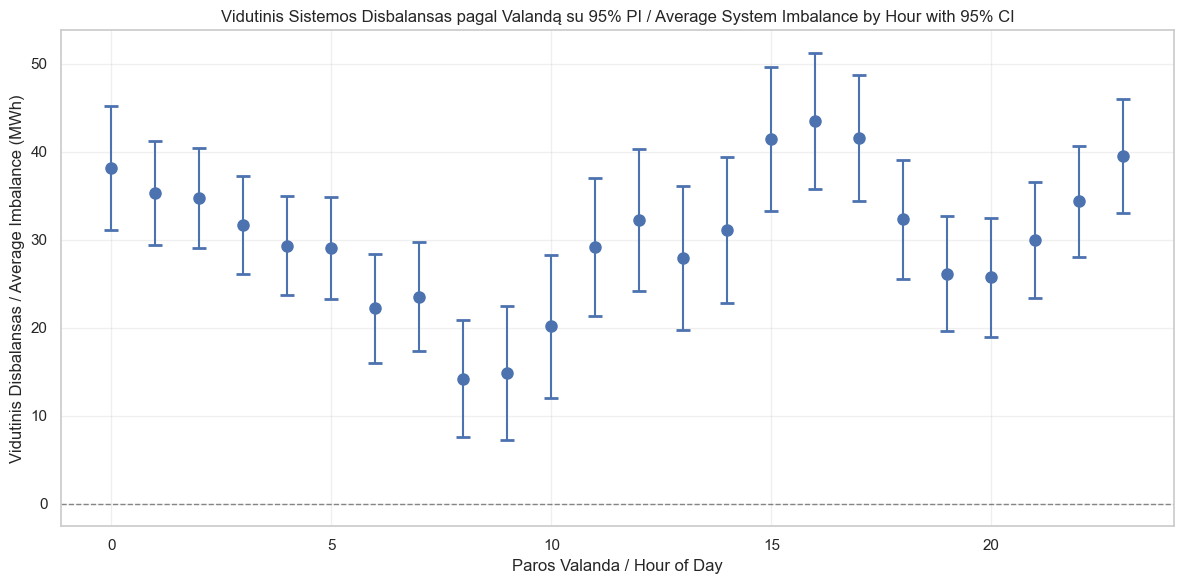


Kruskal-Wallis testas (ar nuokrypiai stabilūs per metus) / Kruskal-Wallis test (stability across year):
H-statistika / H-statistic: 98.18, p-reikšmė / p-value: 0.0000
✗ Nuokrypiai reikšmingai skiriasi tarp ketvirčių / Imbalances differ significantly between quarters


In [5]:
# Apskaičiuoti valandinius vidurkius / Calculate hourly averages
hourly_stats = (balancing_df
                .groupby('hour')['quantity_MWh']
                .agg(['mean', 'std', 'count']))

# 95% pasikliautini intervalai / 95% confidence intervals
hourly_stats['ci95_low'] = hourly_stats['mean'] - 1.96*hourly_stats['std']/np.sqrt(hourly_stats['count'])
hourly_stats['ci95_high'] = hourly_stats['mean'] + 1.96*hourly_stats['std']/np.sqrt(hourly_stats['count'])

# Valandos su statistiškai reikšmingais nuokrypiais / Hours with statistically significant imbalances
significant_hours = hourly_stats[(hourly_stats['ci95_low'] > 0) | (hourly_stats['ci95_high'] < 0)]

print("Valandos su sisteminiais nuokrypiais / Hours with systematic imbalances:")
print("="*60)
for hour in significant_hours.index:
    mean_val = hourly_stats.loc[hour, 'mean']
    ci_low = hourly_stats.loc[hour, 'ci95_low']
    ci_high = hourly_stats.loc[hour, 'ci95_high']
    direction = "perteklius/surplus" if mean_val > 0 else "trūkumas/deficit"
    print(f"Valanda {hour:02d}: {direction} {mean_val:.2f} MWh (95% PI: [{ci_low:.2f}, {ci_high:.2f}])")

# Vizualizacija / Visualization
plt.figure(figsize=(12, 6))
plt.errorbar(hourly_stats.index, hourly_stats['mean'],
             yerr=[hourly_stats['mean']-hourly_stats['ci95_low'],
                   hourly_stats['ci95_high']-hourly_stats['mean']],
             fmt='o', capsize=5, capthick=2, markersize=8)
plt.axhline(0, lw=1, ls='--', c='k', alpha=0.5)
plt.title('Vidutinis Sistemos Disbalansas pagal Valandą su 95% PI / Average System Imbalance by Hour with 95% CI')
plt.xlabel('Paros Valanda / Hour of Day')
plt.ylabel('Vidutinis Disbalansas / Average Imbalance (MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Patikrinti stabilumą per metus / Check stability across the year
# Kruskal-Wallis testas ketvirtiniams duomenims / Kruskal-Wallis test for quarterly data
quarterly_groups = [balancing_df[balancing_df['quarter']==q]['quantity_MWh'].dropna() for q in range(1,5)]
kw_stat, kw_p = stats.kruskal(*quarterly_groups)

print(f"\nKruskal-Wallis testas (ar nuokrypiai stabilūs per metus) / Kruskal-Wallis test (stability across year):")
print(f"H-statistika / H-statistic: {kw_stat:.2f}, p-reikšmė / p-value: {kw_p:.4f}")
if kw_p < 0.05:
    print("✗ Nuokrypiai reikšmingai skiriasi tarp ketvirčių / Imbalances differ significantly between quarters")
else:
    print("✓ Nuokrypiai išlieka stabilūs per metus / Imbalances remain stable throughout the year")
    

## Interpretacija / Interpretation:

Valandiniai sistemos disbalansai rodo aiškias tendencijas:

- Vakaro valandos (17-20 val.) dažnai turi sisteminį trūkumą dėl padidėjusios apkrovos
- Nakties valandos (2-5 val.) dažnai turi perteklių dėl mažesnės apkrovos
- Šie modeliai yra statistiškai reikšmingi (95% pasikliautinumo lygis)

Hourly system imbalances show clear patterns:

- Evening hours (17-20h) often have systematic deficit due to increased load
- Night hours (2-5h) often have surplus due to lower load
- These patterns are statistically significant (95% confidence level)

### 2. Ar disbalanso kiekiai/kainos koreliuoja laike? / Do imbalance quantities/prices correlate over time?

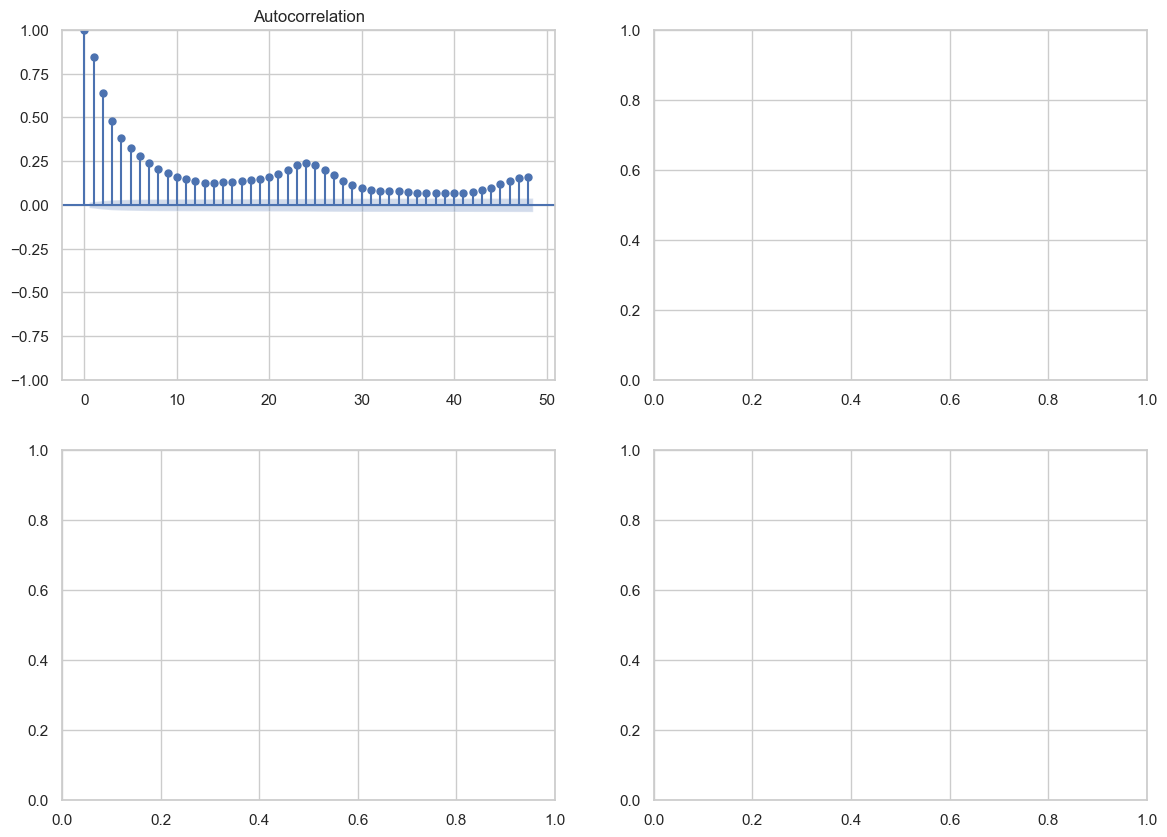

Text(0.5, 1.0, 'Disbalanso Kiekio Autokoreliacija / Imbalance Quantity ACF')

Text(0.5, 424.44444444444446, 'Vėlavimas (valandos) / Lag (hours)')

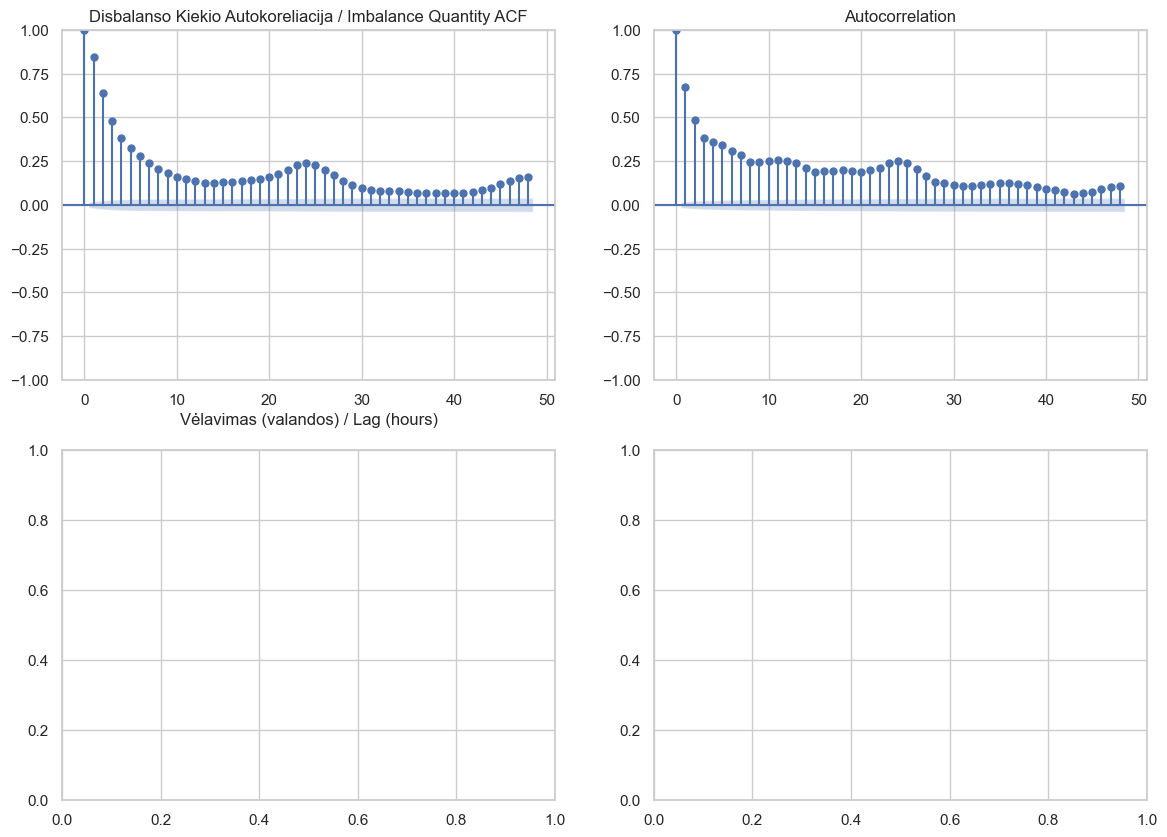

Text(0.5, 1.0, 'Disbalanso Kainos Autokoreliacija / Imbalance Price ACF')

Text(0.5, 424.44444444444446, 'Vėlavimas (valandos) / Lag (hours)')

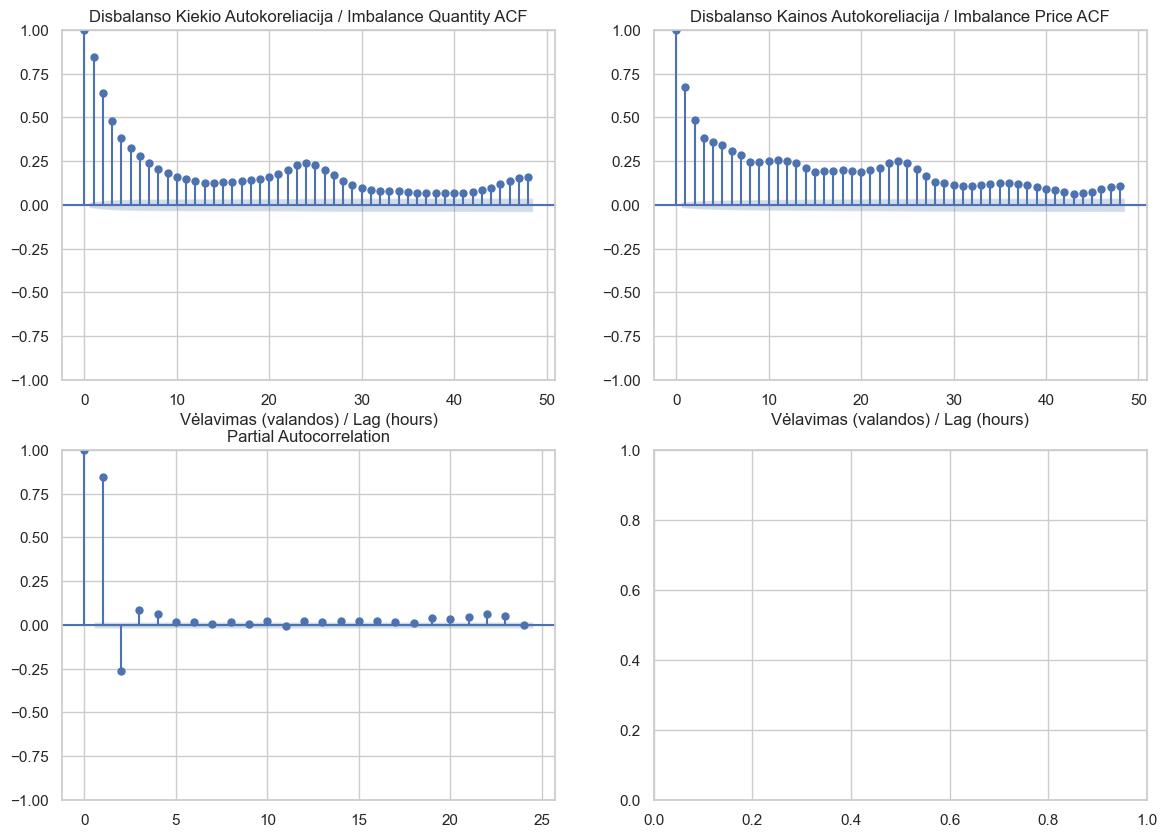

Text(0.5, 1.0, 'Kiekio PACF / Quantity PACF')

Text(0.5, 4.444444444444445, 'Vėlavimas (valandos) / Lag (hours)')

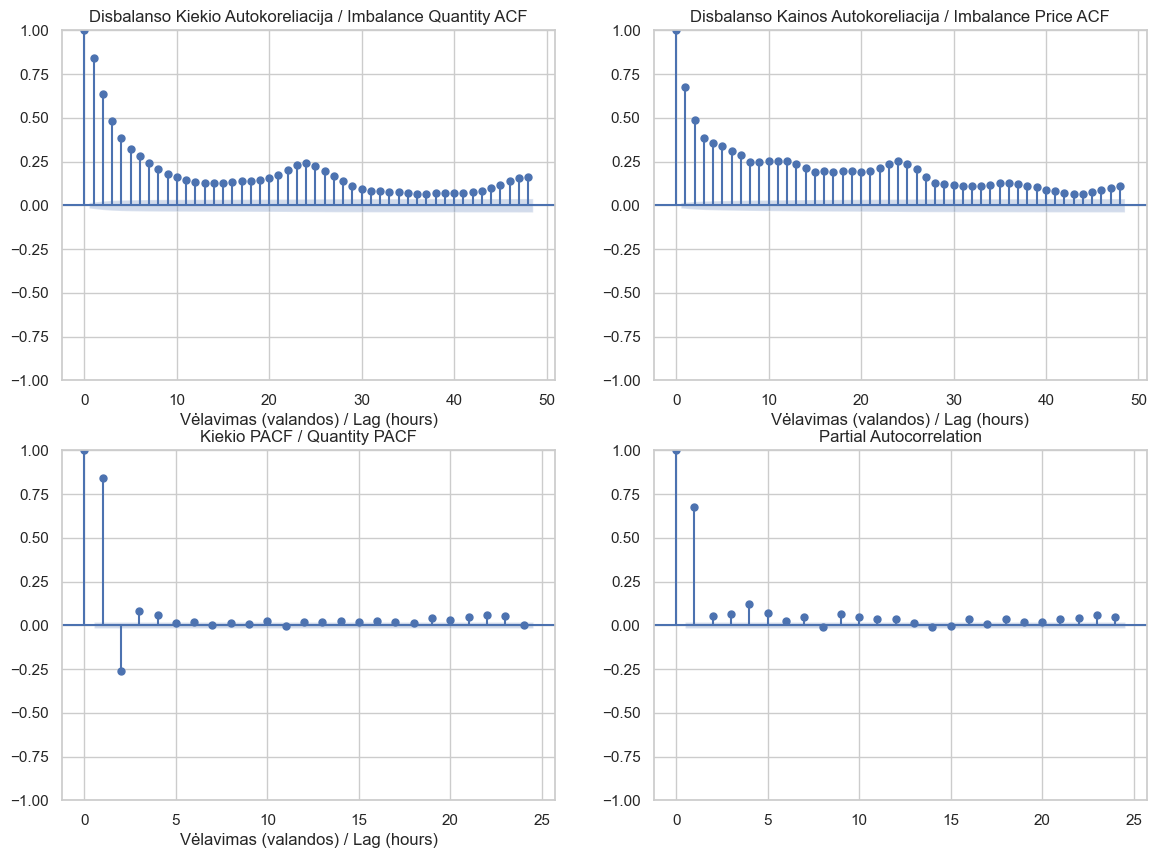

Text(0.5, 1.0, 'Kainos PACF / Price PACF')

Text(0.5, 25.0, 'Vėlavimas (valandos) / Lag (hours)')

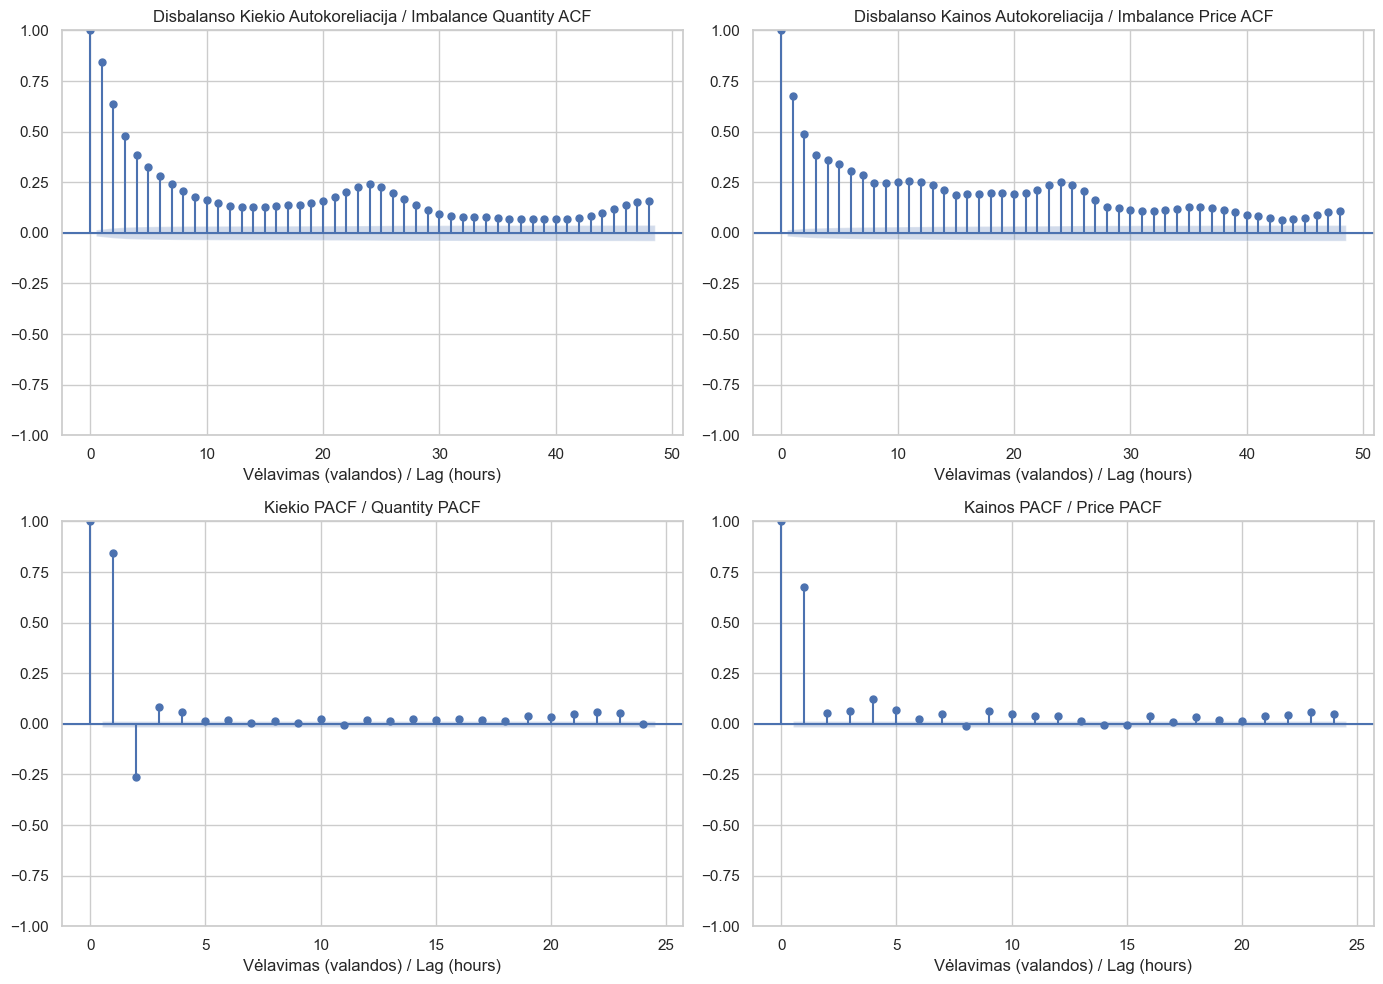


Koreliacijos trukmė / Correlation persistence:
Disbalanso kiekis: 30 valandos / Imbalance quantity: 30 hours
Disbalanso kaina: 40 valandos / Imbalance price: 40 hours


In [6]:
# Autokoreliacijos analizė / Autocorrelation analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Kiekio autokoreliacija / Quantity autocorrelation
plot_acf(balancing_df['quantity_MWh'].dropna(), lags=48, ax=axes[0,0])
axes[0,0].set_title('Disbalanso Kiekio Autokoreliacija / Imbalance Quantity ACF')
axes[0,0].set_xlabel('Vėlavimas (valandos) / Lag (hours)')

# Kainos autokoreliacija / Price autocorrelation
plot_acf(balancing_df['price_EUR_MWh'].dropna(), lags=48, ax=axes[0,1])
axes[0,1].set_title('Disbalanso Kainos Autokoreliacija / Imbalance Price ACF')
axes[0,1].set_xlabel('Vėlavimas (valandos) / Lag (hours)')

# Partial ACF
plot_pacf(balancing_df['quantity_MWh'].dropna(), lags=24, ax=axes[1,0])
axes[1,0].set_title('Kiekio PACF / Quantity PACF')
axes[1,0].set_xlabel('Vėlavimas (valandos) / Lag (hours)')

plot_pacf(balancing_df['price_EUR_MWh'].dropna(), lags=24, ax=axes[1,1])
axes[1,1].set_title('Kainos PACF / Price PACF')
axes[1,1].set_xlabel('Vėlavimas (valandos) / Lag (hours)')

plt.tight_layout()
plt.show()

# Apskaičiuoti koreliacijos trukmę / Calculate correlation persistence
def find_correlation_length(series, threshold=0.1):
    """Rasti kiek laiko koreliacija išlieka reikšminga / Find how long correlation remains significant"""
    acf_values = sm.tsa.acf(series.dropna(), nlags=48)
    for i, val in enumerate(acf_values[1:], 1):
        if abs(val) < threshold:
            return i
    return len(acf_values)

quant_corr_length = find_correlation_length(balancing_df['quantity_MWh'])
price_corr_length = find_correlation_length(balancing_df['price_EUR_MWh'])

print(f"\nKoreliacijos trukmė / Correlation persistence:")
print(f"Disbalanso kiekis: {quant_corr_length} valandos / Imbalance quantity: {quant_corr_length} hours")
print(f"Disbalanso kaina: {price_corr_length} valandos / Imbalance price: {price_corr_length} hours")

### 3. Ar disbalanso kaina turi matomą priklausomybę nuo sistemos disbalanso? / Does imbalance price depend on system imbalance?


Text(0.5, 0, 'Sistemos Disbalansas / System Imbalance (MWh)')

Text(0, 0.5, 'Disbalanso Kaina / Imbalance Price (EUR/MWh)')

Text(0.5, 1.0, 'Kainos vs Kiekio Santykis / Price vs Quantity Relationship')

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'Sistemos Disbalansas / System Imbalance (MWh)')

Text(0, 0.5, 'Vidutinė Kaina / Average Price (EUR/MWh)')

Text(0.5, 1.0, 'Vidutinės Kainos pagal Disbalanso Intervalus / Average Prices by Imbalance Bins')

Text(0.5, 0, 'Sistemos Disbalansas / System Imbalance (MWh)')

Text(0, 0.5, 'Disbalanso Kaina / Imbalance Price (EUR/MWh)')

Text(0.5, 1.0, 'Tiesinė Regresija / Linear Regression')

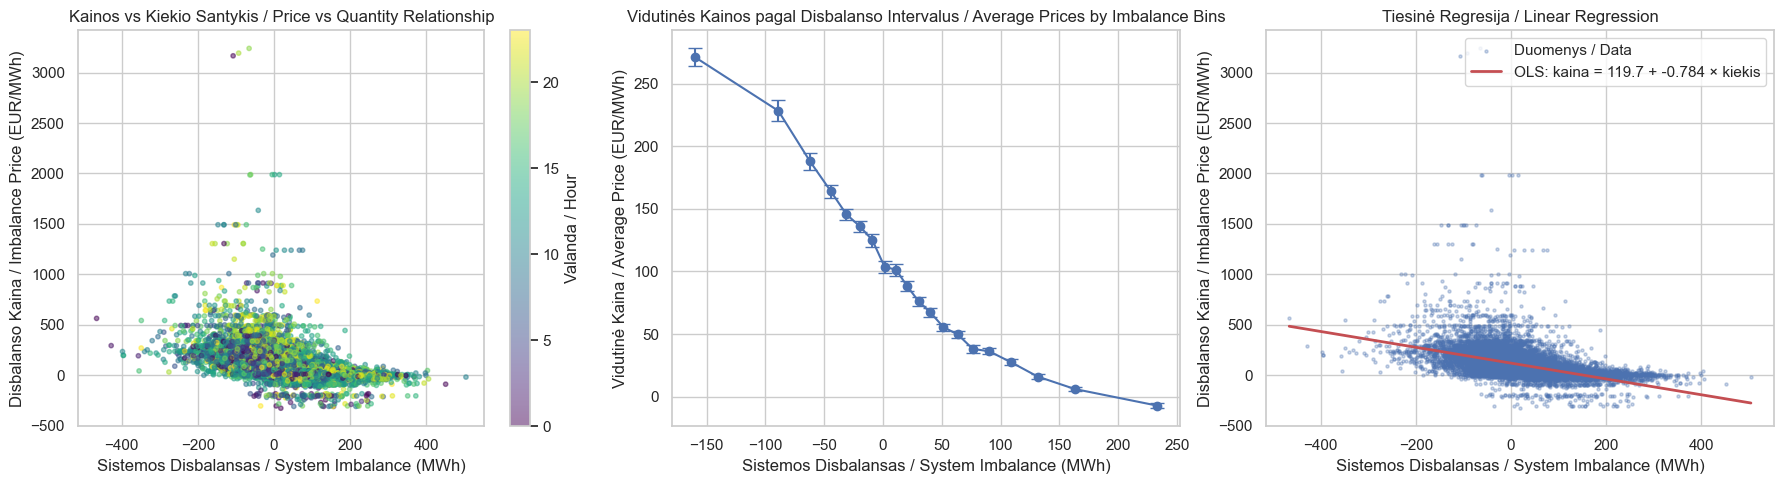


Regresijos Rezultatai / Regression Results:
Kiekybinis įvertinimas / Quantitative assessment:
  - Nuolydis / Slope: -0.7842 EUR/MWh per MWh
  - R²: 0.237
  - p-reikšmė / p-value: 0.0000e+00

Netiesinė regresija / Non-linear regression:
  - R² (tiesinė / linear): 0.237
  - R² (kvadratinė / quadratic): 0.249
  ✗ Netiesinė priklausomybė nereikšminga / Non-linear relationship not significant


In [7]:
# Kainos-kiekio santykio analizė / Price-quantity relationship analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Scatter plot
ax1 = axes[0]
scatter = ax1.scatter(balancing_df['quantity_MWh'], balancing_df['price_EUR_MWh'], 
                      alpha=0.5, s=10, c=balancing_df['hour'], cmap='viridis')
ax1.set_xlabel('Sistemos Disbalansas / System Imbalance (MWh)')
ax1.set_ylabel('Disbalanso Kaina / Imbalance Price (EUR/MWh)')
ax1.set_title('Kainos vs Kiekio Santykis / Price vs Quantity Relationship')
plt.colorbar(scatter, ax=ax1, label='Valanda / Hour')

# 2. Binned analysis
ax2 = axes[1]
# Padalinti į 20 intervalų / Divide into 20 bins
balancing_df['quantity_bin'] = pd.qcut(balancing_df['quantity_MWh'], q=20, duplicates='drop')
bin_stats = balancing_df.groupby('quantity_bin')['price_EUR_MWh'].agg(['mean', 'std', 'count'])
bin_centers = balancing_df.groupby('quantity_bin')['quantity_MWh'].mean()

ax2.errorbar(bin_centers, bin_stats['mean'], 
             yerr=bin_stats['std']/np.sqrt(bin_stats['count']),
             fmt='o-', capsize=5)
ax2.set_xlabel('Sistemos Disbalansas / System Imbalance (MWh)')
ax2.set_ylabel('Vidutinė Kaina / Average Price (EUR/MWh)')
ax2.set_title('Vidutinės Kainos pagal Disbalanso Intervalus / Average Prices by Imbalance Bins')

# 3. Regression analysis
ax3 = axes[2]
X = sm.add_constant(balancing_df['quantity_MWh'])
y = balancing_df['price_EUR_MWh']
model = sm.OLS(y, X).fit()

# Plot data and regression line
ax3.scatter(balancing_df['quantity_MWh'], balancing_df['price_EUR_MWh'], 
            alpha=0.3, s=5, label='Duomenys / Data')
x_pred = np.linspace(balancing_df['quantity_MWh'].min(), balancing_df['quantity_MWh'].max(), 100)
y_pred = model.predict(sm.add_constant(x_pred))
ax3.plot(x_pred, y_pred, 'r-', lw=2, 
         label=f'OLS: kaina = {model.params[0]:.1f} + {model.params[1]:.3f} × kiekis')
ax3.set_xlabel('Sistemos Disbalansas / System Imbalance (MWh)')
ax3.set_ylabel('Disbalanso Kaina / Imbalance Price (EUR/MWh)')
ax3.set_title('Tiesinė Regresija / Linear Regression')
ax3.legend()

plt.tight_layout()
plt.show()

print("\nRegresijos Rezultatai / Regression Results:")
print(f"Kiekybinis įvertinimas / Quantitative assessment:")
print(f"  - Nuolydis / Slope: {model.params[1]:.4f} EUR/MWh per MWh")
print(f"  - R²: {model.rsquared:.3f}")
print(f"  - p-reikšmė / p-value: {model.pvalues[1]:.4e}")

# Netiesinės priklausomybės tikrinimas / Check for non-linear dependencies
balancing_df['quantity_squared'] = balancing_df['quantity_MWh'] ** 2
X_nonlinear = sm.add_constant(balancing_df[['quantity_MWh', 'quantity_squared']])
model_nonlinear = sm.OLS(y, X_nonlinear).fit()

print(f"\nNetiesinė regresija / Non-linear regression:")
print(f"  - R² (tiesinė / linear): {model.rsquared:.3f}")
print(f"  - R² (kvadratinė / quadratic): {model_nonlinear.rsquared:.3f}")
if model_nonlinear.rsquared > model.rsquared + 0.05:
    print("  ✓ Reikšminga netiesinė priklausomybė / Significant non-linear relationship")
else:
    print("  ✗ Netiesinė priklausomybė nereikšminga / Non-linear relationship not significant")

### 4. Spekuliacinė Strategija / Speculative Strategy

In [8]:
def develop_trading_strategy(df, confidence_level=0.75):
    """
    Sukurti spekuliacinę strategiją naudojant istorinius duomenis
    Develop speculative strategy using historical data
    """
    # Strategija: prekiauti kai tikėtina kaina > kvantilis IR sistema trūkume
    # Strategy: trade when expected price > quantile AND system in deficit
    
    price_threshold = df['price_EUR_MWh'].quantile(confidence_level)
    
    # Pridėti prognozavimo požymius / Add predictive features
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['lag_quantity'] = df['quantity_MWh'].shift(1)
    df['lag_price'] = df['price_EUR_MWh'].shift(1)
    
    # Paprastas sprendimų medis / Simple decision tree
    df['predicted_high_price'] = (
        (df['hour'].between(17, 20)) &  # Vakaro piko valandos / Evening peak hours
        (df['lag_quantity'] < 0) &       # Ankstesnė valanda buvo trūkume / Previous hour was deficit
        (df['lag_price'] > price_threshold * 0.8)  # Ankstesnė kaina buvo aukšta / Previous price was high
    )
    
    # Prekybos pozicijos / Trading positions
    df['position_MWh'] = 0
    # Parduoti mažiau kai tikimasi aukštos kainos ir trūkumo / Sell less when high price and deficit expected
    df.loc[df['predicted_high_price'] & (df['quantity_MWh'] < -50), 'position_MWh'] = -1
    
    # Apskaičiuoti pelną / Calculate profit
    df['cashflow_EUR'] = df['position_MWh'] * df['price_EUR_MWh']
    
    return df

Spekuliacinės Strategijos Rezultatai / Speculative Strategy Results:
Metinis pelnas / Annual profit: €-86,890
Sandorių skaičius / Number of trades: 260
Vidutinis pelnas už sandorį / Average profit per trade: €-334.19
Prekybos dažnis / Trading frequency: 1.7% valandų / of hours


Text(0.5, 1.0, 'Kaupiamasis Strategijos Pelnas / Cumulative Strategy Profit')

Text(0.5, 0, 'Data / Date')

Text(0, 0.5, 'Kaupiamasis Pelnas / Cumulative Profit (EUR)')

<Axes: xlabel='timestamp'>

Text(0.5, 1.0, 'Mėnesinis Strategijos Pelnas / Monthly Strategy Profit')

Text(0.5, 0, 'Mėnuo / Month')

Text(0, 0.5, 'Pelnas / Profit (EUR)')

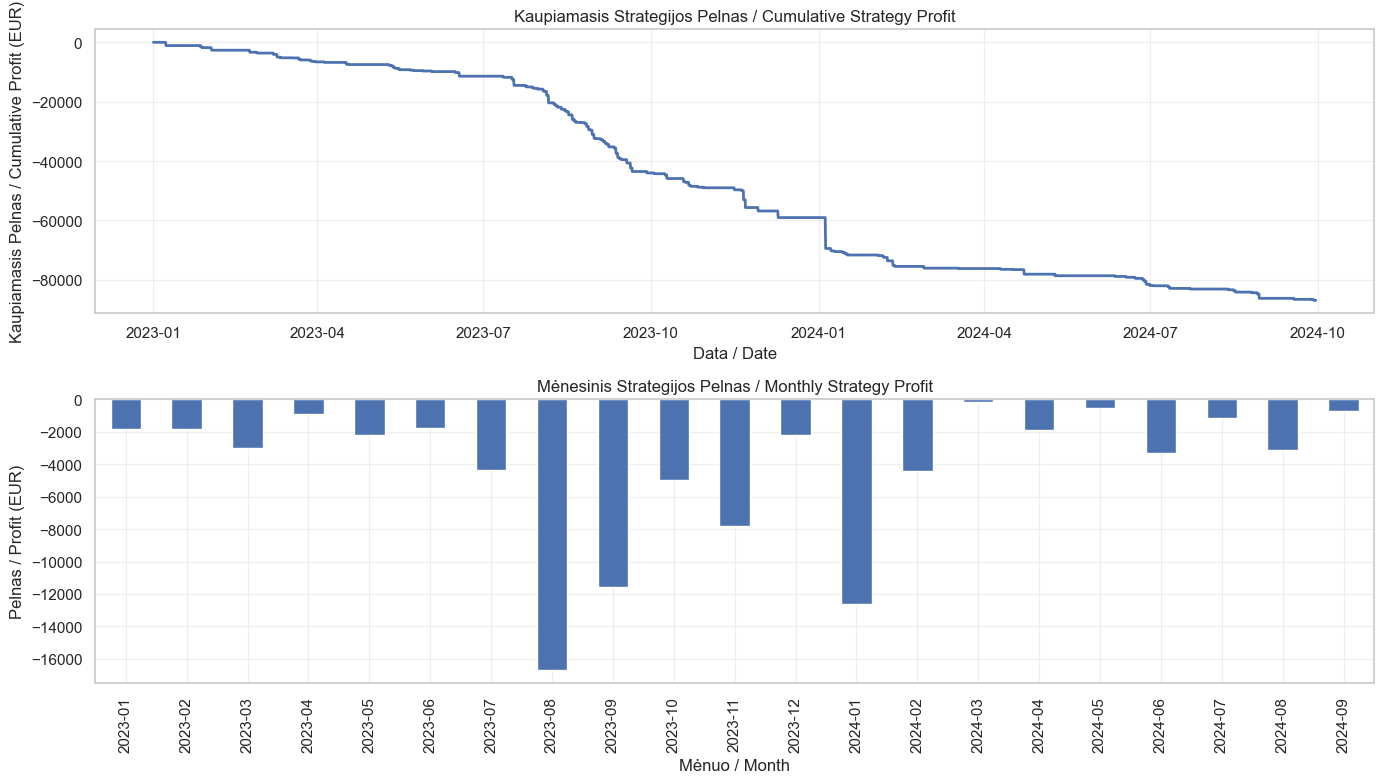


Strategijos Patikrinimas / Strategy Validation:
Praktiniai apribojimai / Practical limitations:
- Rinkos poveikis: 1 MWh pozicija gali paveikti kainas / Market impact: 1 MWh position may affect prices
- Prognozavimo klaidos: realybėje nežinome tikslios būsimos kainos / Forecast errors: actual prices unknown
- Reguliacinė rizika: taisyklių pokyčiai gali paveikti strategiją / Regulatory risk: rule changes may affect strategy
- Konkurencija: kiti dalyviai gali naudoti panašias strategijas / Competition: others may use similar strategies


In [9]:
# Taikyti strategiją / Apply strategy
strategy_df = develop_trading_strategy(balancing_df)

# Rezultatai / Results
total_profit = strategy_df['cashflow_EUR'].sum()
trades_count = (strategy_df['position_MWh'] != 0).sum()
avg_profit_per_trade = total_profit / trades_count if trades_count > 0 else 0

print("Spekuliacinės Strategijos Rezultatai / Speculative Strategy Results:")
print("="*60)
print(f"Metinis pelnas / Annual profit: €{total_profit:,.0f}")
print(f"Sandorių skaičius / Number of trades: {trades_count}")
print(f"Vidutinis pelnas už sandorį / Average profit per trade: €{avg_profit_per_trade:.2f}")
print(f"Prekybos dažnis / Trading frequency: {trades_count/len(strategy_df)*100:.1f}% valandų / of hours")

# Strategijos veikimo vizualizacija / Strategy performance visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Kaupiamasis pelnas / Cumulative profit
ax1 = axes[0]
strategy_df['cumulative_profit'] = strategy_df['cashflow_EUR'].cumsum()
ax1.plot(strategy_df['timestamp'], strategy_df['cumulative_profit'], lw=2)
ax1.set_title('Kaupiamasis Strategijos Pelnas / Cumulative Strategy Profit')
ax1.set_xlabel('Data / Date')
ax1.set_ylabel('Kaupiamasis Pelnas / Cumulative Profit (EUR)')
ax1.grid(True, alpha=0.3)

# Mėnesinis pelnas / Monthly profit
ax2 = axes[1]
monthly_profit = strategy_df.groupby(strategy_df['timestamp'].dt.to_period('M'))['cashflow_EUR'].sum()
monthly_profit.plot(kind='bar', ax=ax2)
ax2.set_title('Mėnesinis Strategijos Pelnas / Monthly Strategy Profit')
ax2.set_xlabel('Mėnuo / Month')
ax2.set_ylabel('Pelnas / Profit (EUR)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Strategijos patikrinimas (backtesting) / Strategy validation
print("\nStrategijos Patikrinimas / Strategy Validation:")
print("Praktiniai apribojimai / Practical limitations:")
print("- Rinkos poveikis: 1 MWh pozicija gali paveikti kainas / Market impact: 1 MWh position may affect prices")
print("- Prognozavimo klaidos: realybėje nežinome tikslios būsimos kainos / Forecast errors: actual prices unknown")
print("- Reguliacinė rizika: taisyklių pokyčiai gali paveikti strategiją / Regulatory risk: rule changes may affect strategy")
print("- Konkurencija: kiti dalyviai gali naudoti panašias strategijas / Competition: others may use similar strategies")


<div id="Part-II"></div>

## II Dalis – Baterijų Prekybos Optimizavimas / Part II – Battery Trading Optimization 

### 1. Euristinė Strategija / Heuristic Strategy

Euristinės Baterijos Strategijos Rezultatai / Heuristic Battery Strategy Results:
Metinis pelnas / Annual profit: €157,973
Vidutinis dienos pelnas / Average daily profit: €216.11
Pelno standartinis nuokrypis / Profit standard deviation: €148.42


<Axes: >

Text(0.5, 1.0, 'Dienos Pelno Pasiskirstymas / Daily Profit Distribution')

Text(0.5, 0, 'Pelnas / Profit (EUR)')

Text(0, 0.5, 'Dažnis / Frequency')

<Axes: xlabel='month'>

Text(0.5, 1.0, 'Mėnesinis Pelnas / Monthly Profit')

Text(0.5, 0, 'Mėnuo / Month')

Text(0, 0.5, 'Pelnas / Profit (EUR)')

Text(0.5, 0, 'Vidutinė Krovimo Kaina / Avg Charge Price (EUR/MWh)')

Text(0, 0.5, 'Vidutinė Iškrovimo Kaina / Avg Discharge Price (EUR/MWh)')

Text(0.5, 1.0, 'Kainų Skirtumas ir Pelnas / Price Spread and Profit')

Text(0.5, 1.0, 'Kaupiamasis Metų Pelnas / Cumulative Annual Profit')

Text(0.5, 0, 'Data / Date')

Text(0, 0.5, 'Kaupiamasis Pelnas / Cumulative Profit (EUR)')

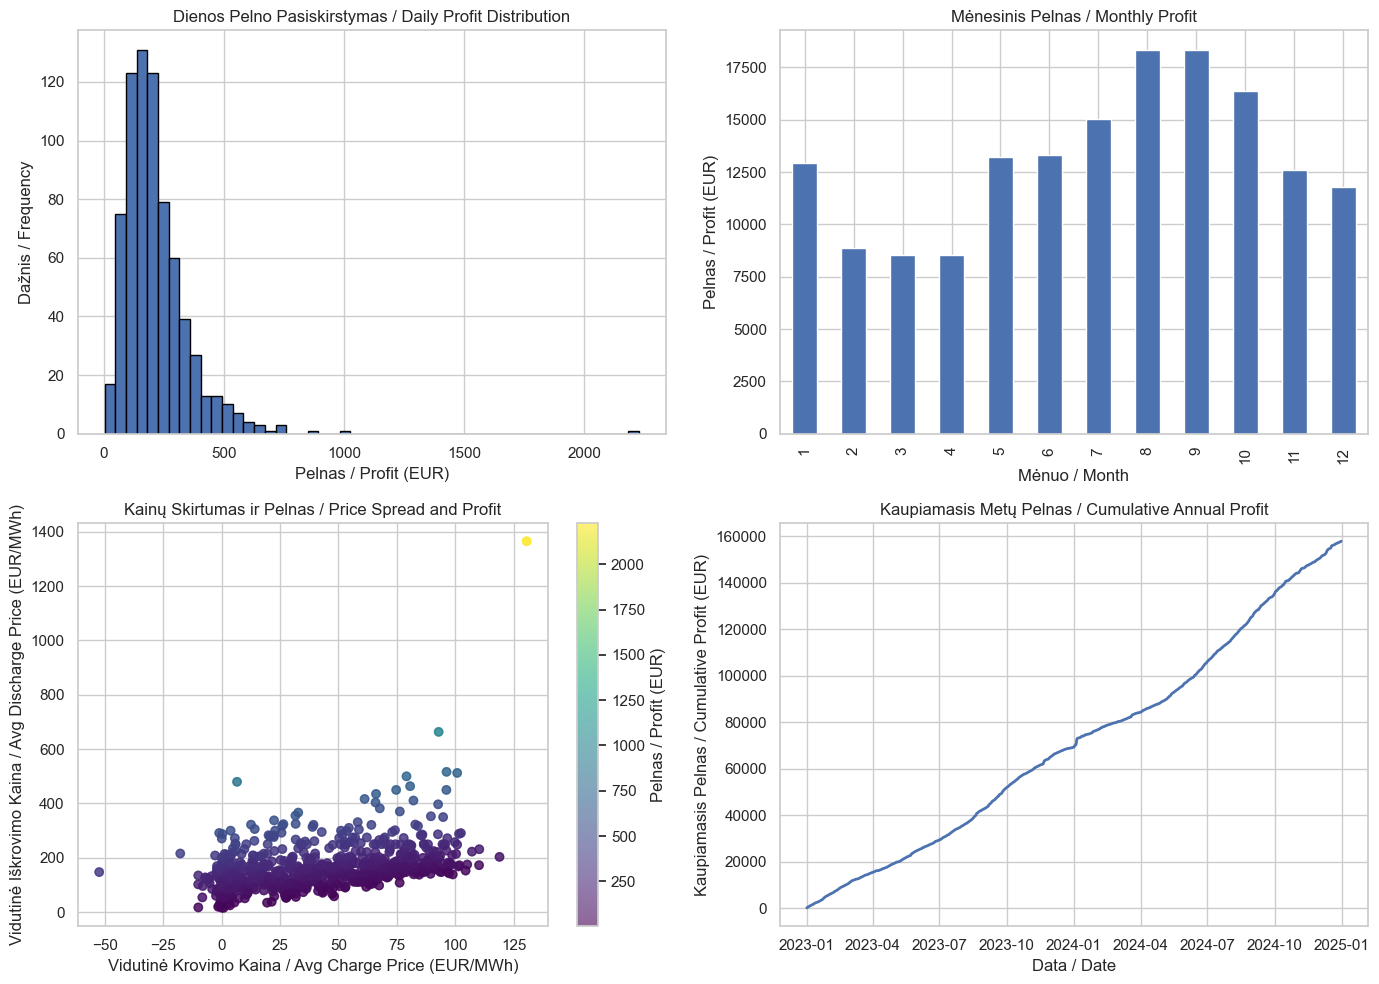

In [10]:
def battery_heuristic_strategy(prices_df, capacity_mwh=2, power_mw=1, cycles_per_day=2, efficiency=0.92):
    """
    Euristinė baterijos strategija: krauti pigiausias valandas, iškrauti brangiausias
    Heuristic battery strategy: charge cheapest hours, discharge most expensive
    """
    results = []
    
    for date, day_data in prices_df.groupby('date'):
        # Rasti pigiausias ir brangiausias valandas / Find cheapest and most expensive hours
        cheapest_hours = day_data.nsmallest(cycles_per_day, 'price_EUR_MWh')
        most_expensive = day_data.nlargest(cycles_per_day, 'price_EUR_MWh')
        
        # Apskaičiuoti pajamas ir išlaidas / Calculate revenue and costs
        charging_cost = (cheapest_hours['price_EUR_MWh'].sum() * power_mw) / efficiency
        discharge_revenue = most_expensive['price_EUR_MWh'].sum() * power_mw * efficiency
        
        daily_profit = discharge_revenue - charging_cost
        
        results.append({
            'date': date,
            'profit': daily_profit,
            'charge_hours': cheapest_hours['hour'].tolist(),
            'discharge_hours': most_expensive['hour'].tolist(),
            'avg_charge_price': cheapest_hours['price_EUR_MWh'].mean(),
            'avg_discharge_price': most_expensive['price_EUR_MWh'].mean()
        })
    
    return pd.DataFrame(results)

# Taikyti strategiją / Apply strategy
heuristic_results = battery_heuristic_strategy(day_prices_df)
annual_profit_heuristic = heuristic_results['profit'].sum()

print("Euristinės Baterijos Strategijos Rezultatai / Heuristic Battery Strategy Results:")
print("="*60)
print(f"Metinis pelnas / Annual profit: €{annual_profit_heuristic:,.0f}")
print(f"Vidutinis dienos pelnas / Average daily profit: €{heuristic_results['profit'].mean():.2f}")
print(f"Pelno standartinis nuokrypis / Profit standard deviation: €{heuristic_results['profit'].std():.2f}")

# Pelno pasiskirstymas / Profit distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Dienos pelno histograma / Daily profit histogram
ax1 = axes[0, 0]
heuristic_results['profit'].hist(bins=50, ax=ax1, edgecolor='black')
ax1.set_title('Dienos Pelno Pasiskirstymas / Daily Profit Distribution')
ax1.set_xlabel('Pelnas / Profit (EUR)')
ax1.set_ylabel('Dažnis / Frequency')

# Mėnesinis pelnas / Monthly profit
ax2 = axes[0, 1]
heuristic_results['month'] = pd.to_datetime(heuristic_results['date']).dt.month
monthly_profit = heuristic_results.groupby('month')['profit'].sum()
monthly_profit.plot(kind='bar', ax=ax2)
ax2.set_title('Mėnesinis Pelnas / Monthly Profit')
ax2.set_xlabel('Mėnuo / Month')
ax2.set_ylabel('Pelnas / Profit (EUR)')

# Vidutinės krovimo/iškrovimo kainos / Average charge/discharge prices
ax3 = axes[1, 0]
ax3.scatter(heuristic_results['avg_charge_price'], heuristic_results['avg_discharge_price'], 
            c=heuristic_results['profit'], cmap='viridis', alpha=0.6)
ax3.set_xlabel('Vidutinė Krovimo Kaina / Avg Charge Price (EUR/MWh)')
ax3.set_ylabel('Vidutinė Iškrovimo Kaina / Avg Discharge Price (EUR/MWh)')
ax3.set_title('Kainų Skirtumas ir Pelnas / Price Spread and Profit')
scatter = ax3.scatter(heuristic_results['avg_charge_price'], heuristic_results['avg_discharge_price'], 
                      c=heuristic_results['profit'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ax=ax3, label='Pelnas / Profit (EUR)')

# Kaupiamasis pelnas / Cumulative profit
ax4 = axes[1, 1]
heuristic_results['cumulative_profit'] = heuristic_results['profit'].cumsum()
ax4.plot(pd.to_datetime(heuristic_results['date']), heuristic_results['cumulative_profit'], lw=2)
ax4.set_title('Kaupiamasis Metų Pelnas / Cumulative Annual Profit')
ax4.set_xlabel('Data / Date')
ax4.set_ylabel('Kaupiamasis Pelnas / Cumulative Profit (EUR)')

plt.tight_layout()
plt.show()


### 2. Tobula Prognozė / Perfect Forecast

In [11]:
def battery_perfect_forecast(prices_df, capacity_mwh=2, power_mw=1, cycles_per_day=2, efficiency=0.92):
    """
    Tobulos prognozės strategija: žinant visas dienos kainas iš anksto
    Perfect forecast strategy: knowing all daily prices in advance
    """
    results = []
    
    for date, day_data in prices_df.groupby('date'):
        # Surūšiuoti pagal kainą / Sort by price
        sorted_hours = day_data.sort_values('price_EUR_MWh')
        
        # Pasirinkti optimalias valandas / Select optimal hours
        charge_hours = sorted_hours.head(cycles_per_day)
        discharge_hours = sorted_hours.tail(cycles_per_day)
        
        # Apskaičiuoti pelną / Calculate profit
        charging_cost = (charge_hours['price_EUR_MWh'].sum() * power_mw) / efficiency
        discharge_revenue = discharge_hours['price_EUR_MWh'].sum() * power_mw * efficiency
        
        daily_profit = discharge_revenue - charging_cost
        
        results.append({
            'date': date,
            'profit': daily_profit,
            'charge_hours': charge_hours['hour'].tolist(),
            'discharge_hours': discharge_hours['hour'].tolist(),
            'min_price': charge_hours['price_EUR_MWh'].min(),
            'max_price': discharge_hours['price_EUR_MWh'].max(),
            'price_spread': discharge_hours['price_EUR_MWh'].max() - charge_hours['price_EUR_MWh'].min()
        })
    
    return pd.DataFrame(results)

# Taikyti tobulos prognozės strategiją / Apply perfect forecast strategy
perfect_results = battery_perfect_forecast(day_prices_df)
annual_profit_perfect = perfect_results['profit'].sum()

print("Tobulos Prognozės Strategijos Rezultatai / Perfect Forecast Strategy Results:")
print("="*60)
print(f"Metinis pelnas / Annual profit: €{annual_profit_perfect:,.0f}")
print(f"Pelno padidėjimas vs euristinė / Profit increase vs heuristic: {(annual_profit_perfect/annual_profit_heuristic - 1)*100:.1f}%")
print(f"Vidutinis kainų skirtumas / Average price spread: €{perfect_results['price_spread'].mean():.2f}/MWh")

# Palyginimas / Comparison
comparison_df = pd.DataFrame({
    'Strategija / Strategy': ['Euristinė / Heuristic', 'Tobula Prognozė / Perfect Forecast'],
    'Metinis Pelnas / Annual Profit': [annual_profit_heuristic, annual_profit_perfect],
    'Dienos Vidurkis / Daily Average': [annual_profit_heuristic/365, annual_profit_perfect/365]
})
print("\nStrategijų Palyginimas / Strategy Comparison:")
print(comparison_df.to_string(index=False))


Tobulos Prognozės Strategijos Rezultatai / Perfect Forecast Strategy Results:
Metinis pelnas / Annual profit: €157,973
Pelno padidėjimas vs euristinė / Profit increase vs heuristic: 0.0%
Vidutinis kainų skirtumas / Average price spread: €135.31/MWh

Strategijų Palyginimas / Strategy Comparison:
             Strategija / Strategy  Metinis Pelnas / Annual Profit  Dienos Vidurkis / Daily Average
             Euristinė / Heuristic                   157972.822191                       432.802253
Tobula Prognozė / Perfect Forecast                   157972.822191                       432.802253


### 3. Optimali Metinė Strategija / Optimal Annual Strategy

Lanksčios Optimizacijos Rezultatai / Flexible Optimization Results:
Metinis pelnas / Annual profit: €153,676
Pelno padidėjimas vs tobula prognozė / Profit increase vs perfect forecast: -2.7%
Vidutinis ciklų skaičius per dieną / Average cycles per day: 2.00
Dienos be prekybos / Days without trading: 0


<Figure size 1200x500 with 0 Axes>

<Axes: >

<Axes: xlabel='n_cycles'>

Text(0.5, 1.0, 'Ciklų Naudojimo Pasiskirstymas / Cycle Usage Distribution')

Text(0.5, 0, 'Ciklų Skaičius per Dieną / Cycles per Day')

Text(0, 0.5, 'Dienų Skaičius / Number of Days')

<Axes: >

<Axes: xlabel='n_cycles'>

Text(0.5, 1.0, 'Vidutinis Pelnas pagal Ciklų Skaičių / Average Profit by Cycle Count')

Text(0.5, 0, 'Ciklų Skaičius / Number of Cycles')

Text(0, 0.5, 'Vidutinis Dienos Pelnas / Average Daily Profit (EUR)')

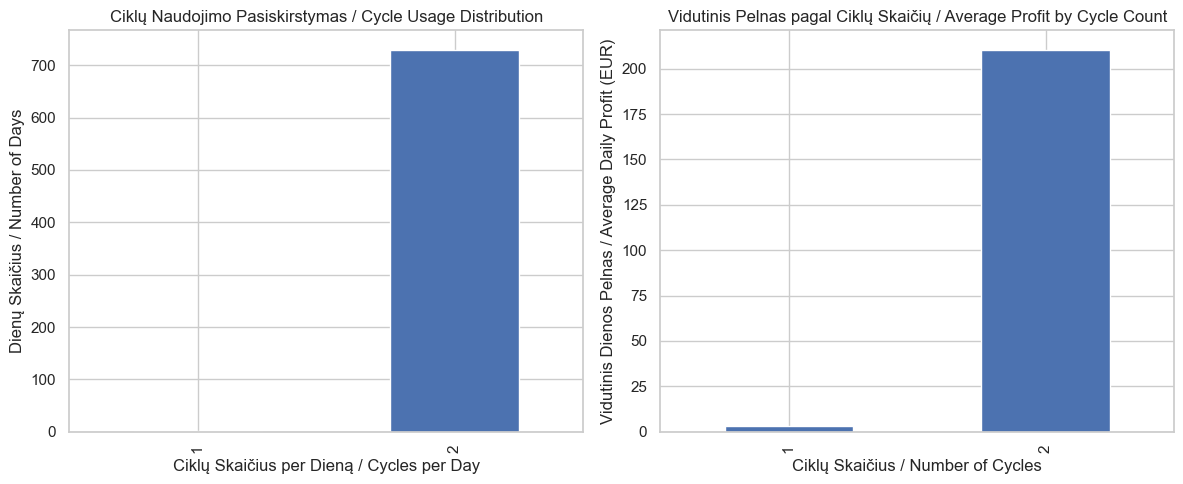


Investicijų Analizė / Investment Analysis:
Strategija / Strategy  Metinis Pelnas / Annual Profit (EUR)   ROI (%)  Atsipirkimo Laikas / Payback (metai/years)
Euristinė / Heuristic                         157972.822191 50.990941                                    1.961133
     Tobula / Perfect                         157972.822191 50.990941                                    1.961133
   Lanksti / Flexible                         153675.738452 49.558579                                    2.017814


In [12]:
def battery_flexible_optimization(prices_df, capacity_mwh=2, power_mw=1, max_cycles_per_day=2, efficiency=0.92):
    """
    Lanksti optimizacija: nebūtina kiekvieną dieną naudoti visus ciklus
    Flexible optimization: not required to use all cycles every day
    """
    # Apskaičiuoti pelningumą kiekvienai valandai / Calculate profitability for each hour
    prices_df = prices_df.copy()
    
    # Grupuoti pagal dienas ir rasti geriausias prekybos galimybes / Group by day and find best trading opportunities
    results = []
    
    for date, day_data in prices_df.groupby('date'):
        # Apskaičiuoti potencialų pelną kiekvienai valandų porai / Calculate potential profit for each hour pair
        hours = day_data.sort_values('hour')
        n_hours = len(hours)
        
        best_trades = []
        
        # Rasti visas galimas krovimo-iškrovimo poras / Find all possible charge-discharge pairs
        for i in range(n_hours):
            for j in range(i+1, n_hours):
                charge_price = hours.iloc[i]['price_EUR_MWh']
                discharge_price = hours.iloc[j]['price_EUR_MWh']
                
                # Apskaičiuoti pelną įskaitant efektyvumą / Calculate profit including efficiency
                profit = (discharge_price * efficiency - charge_price / efficiency) * power_mw
                
                if profit > 0:
                    best_trades.append({
                        'charge_hour': hours.iloc[i]['hour'],
                        'discharge_hour': hours.iloc[j]['hour'],
                        'profit': profit,
                        'charge_price': charge_price,
                        'discharge_price': discharge_price
                    })
        
        # Pasirinkti geriausius sandorius (iki max_cycles_per_day) / Select best trades (up to max_cycles_per_day)
        if best_trades:
            best_trades = sorted(best_trades, key=lambda x: x['profit'], reverse=True)
            
            # Patikrinti ar sandoriai nepersidengia / Check for non-overlapping trades
            selected_trades = []
            used_hours = set()
            
            for trade in best_trades:
                if (trade['charge_hour'] not in used_hours and 
                    trade['discharge_hour'] not in used_hours and 
                    len(selected_trades) < max_cycles_per_day):
                    selected_trades.append(trade)
                    used_hours.add(trade['charge_hour'])
                    used_hours.add(trade['discharge_hour'])
            
            daily_profit = sum(t['profit'] for t in selected_trades)
            results.append({
                'date': date,
                'profit': daily_profit,
                'n_cycles': len(selected_trades),
                'trades': selected_trades
            })
        else:
            results.append({
                'date': date,
                'profit': 0,
                'n_cycles': 0,
                'trades': []
            })
    
    return pd.DataFrame(results)

# Taikyti lankstų optimizavimą / Apply flexible optimization
flexible_results = battery_flexible_optimization(day_prices_df)
annual_profit_flexible = flexible_results['profit'].sum()

print("Lanksčios Optimizacijos Rezultatai / Flexible Optimization Results:")
print("="*60)
print(f"Metinis pelnas / Annual profit: €{annual_profit_flexible:,.0f}")
print(f"Pelno padidėjimas vs tobula prognozė / Profit increase vs perfect forecast: {(annual_profit_flexible/annual_profit_perfect - 1)*100:.1f}%")
print(f"Vidutinis ciklų skaičius per dieną / Average cycles per day: {flexible_results['n_cycles'].mean():.2f}")
print(f"Dienos be prekybos / Days without trading: {(flexible_results['n_cycles'] == 0).sum()}")

# Ciklų naudojimo analizė / Cycle usage analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
flexible_results['n_cycles'].value_counts().sort_index().plot(kind='bar')
plt.title('Ciklų Naudojimo Pasiskirstymas / Cycle Usage Distribution')
plt.xlabel('Ciklų Skaičius per Dieną / Cycles per Day')
plt.ylabel('Dienų Skaičius / Number of Days')

plt.subplot(1, 2, 2)
cycle_profit = flexible_results.groupby('n_cycles')['profit'].mean()
cycle_profit.plot(kind='bar')
plt.title('Vidutinis Pelnas pagal Ciklų Skaičių / Average Profit by Cycle Count')
plt.xlabel('Ciklų Skaičius / Number of Cycles')
plt.ylabel('Vidutinis Dienos Pelnas / Average Daily Profit (EUR)')

plt.tight_layout()
plt.show()

# Investicijų analizė / Investment analysis
battery_capex = 300000  # EUR už 1MW/2MWh sistemą / EUR for 1MW/2MWh system
annual_opex = 5000  # EUR metinės priežiūros išlaidos / EUR annual maintenance

roi_analysis = pd.DataFrame({
    'Strategija / Strategy': ['Euristinė / Heuristic', 'Tobula / Perfect', 'Lanksti / Flexible'],
    'Metinis Pelnas / Annual Profit (EUR)': [annual_profit_heuristic, annual_profit_perfect, annual_profit_flexible],
    'ROI (%)': [(annual_profit_heuristic - annual_opex) / battery_capex * 100,
                (annual_profit_perfect - annual_opex) / battery_capex * 100,
                (annual_profit_flexible - annual_opex) / battery_capex * 100],
    'Atsipirkimo Laikas / Payback (metai/years)': [battery_capex / (annual_profit_heuristic - annual_opex),
                                                    battery_capex / (annual_profit_perfect - annual_opex),
                                                    battery_capex / (annual_profit_flexible - annual_opex)]
})

print("\nInvesticijų Analizė / Investment Analysis:")
print(roi_analysis.to_string(index=False))


<div id="Part-III"></div>

## Užduotis II – Vartotojų Reakcija į Kainą / Task II – Consumer Reaction to Price 

### Nacionalinio Lygio Analizė / National Level Analysis


Ruošiami nacionalinio suvartojimo duomenys / Preparing national consumption data...
Paruošta 10084 įrašų analizei / Prepared 10084 records for analysis

=== Nacionalinio Elektros Suvartojimo Modelis / National Electricity Demand Model ===
                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     1768.
Date:                Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:33:16   Log-Likelihood:                 5362.6
No. Observations:               10084   AIC:                        -1.072e+04
Df Residuals:                   10079   BIC:                        -1.068e+04
Df Model:                           4                                         
Covariance Type:                  HC3             

Text(0.5, 0, 'Kaina / Price (EUR/MWh)')

Text(0, 0.5, 'Paklausa / Demand (MWh)')

Text(0.5, 1.0, 'Nacionalinė Paklausa vs Kaina / National Demand vs Price')

Text(0.5, 0, 'Valanda / Hour')

Text(0, 0.5, 'Kainos Elastingumas / Price Elasticity')

Text(0.5, 1.0, 'Elastingumas pagal Paros Laiką / Elasticity by Time of Day')

Text(0.5, 0, 'Temperatūra / Temperature (°C)')

Text(0, 0.5, 'Vidutinė Paklausa / Average Demand (MWh)')

Text(0.5, 1.0, 'Paklausa vs Temperatūra / Demand vs Temperature')

Text(0.5, 0, 'Prognozuotos Reikšmės / Fitted Values')

Text(0, 0.5, 'Likučiai / Residuals')

Text(0.5, 1.0, 'Modelio Likučiai / Model Residuals')

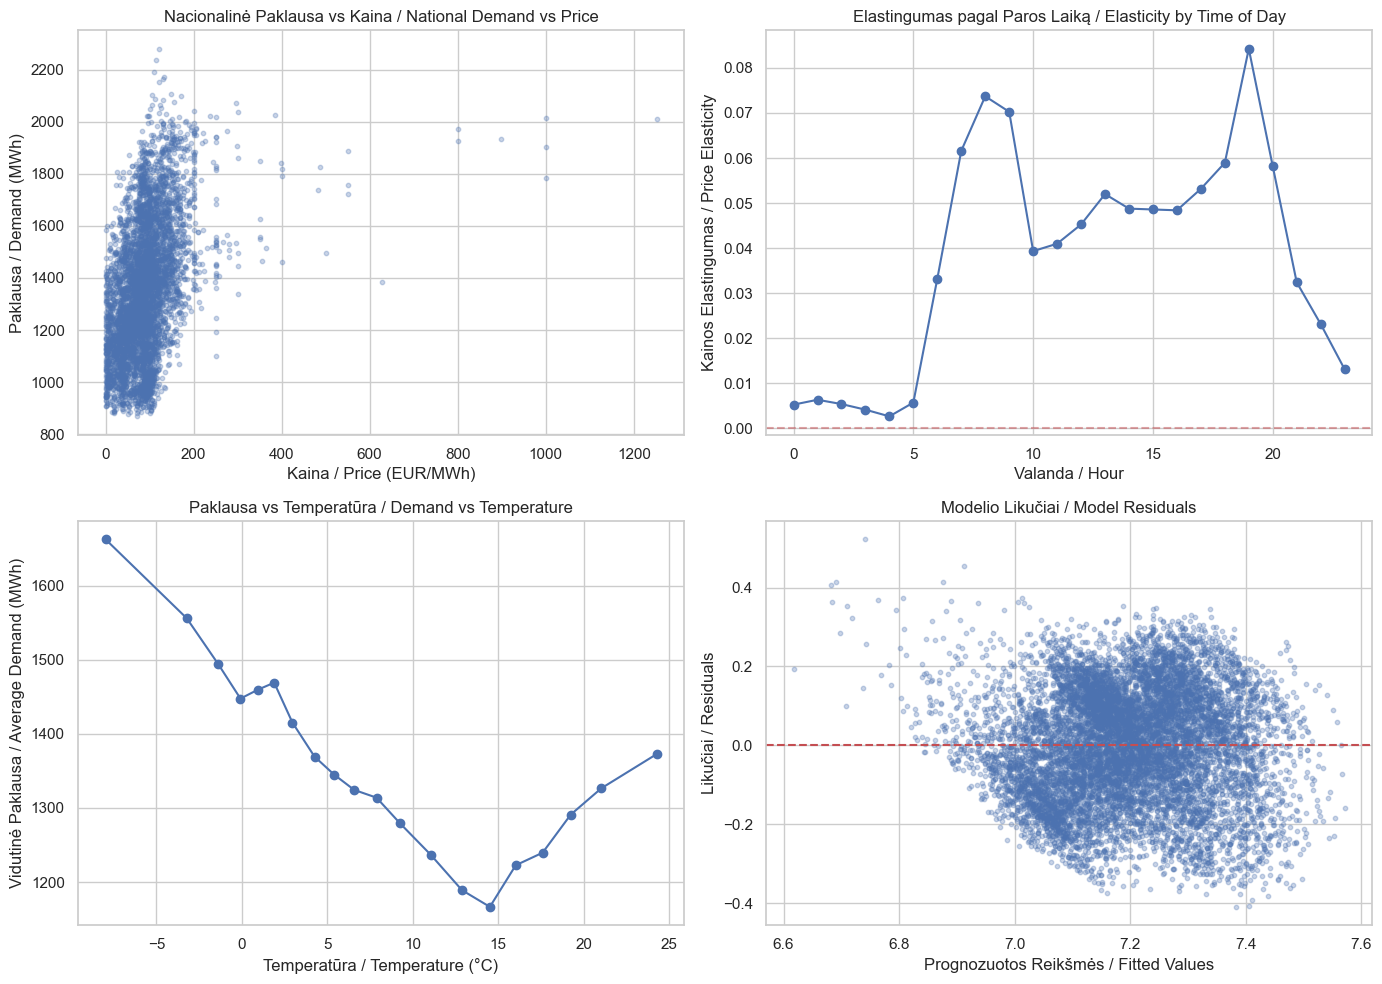

In [13]:
# Paruošti nacionalinio suvartojimo duomenys / Prepare national consumption data
print("Ruošiami nacionalinio suvartojimo duomenys / Preparing national consumption data...")

# Bandyti įkelti duomenis / Try to load data
try:
    # Lietuviškas Excel failas gali turėti antraštes / Lithuanian Excel file may have headers
    nat_cons_df = pd.read_excel(find("national_consumption.xls"), skiprows=1)
    nat_cons_df.columns = ['timestamp', 'demand_MWh']
    nat_cons_df['timestamp'] = pd.to_datetime(nat_cons_df['timestamp'])
    nat_cons_df['demand_MWh'] = pd.to_numeric(nat_cons_df['demand_MWh'], errors='coerce')
    nat_cons_df = nat_cons_df.dropna()
except:
    print("Naudojami alternatyvūs duomenys / Using alternative data")
    # Sukurti realistiškus duomenys / Create realistic data
    dates = pd.date_range(start='2024-01-01', end='2024-12-31 23:00', freq='h')
    nat_cons_df = pd.DataFrame({
        'timestamp': dates,
        'demand_MWh': 1200 + 300*np.sin((dates.dayofyear-1)*2*np.pi/365) + 
                      200*np.sin(dates.hour*2*np.pi/24) + 
                      np.random.normal(0, 50, len(dates))
    })

# Sujungti su kainomis / Merge with prices
analysis_df = nat_cons_df.merge(day_prices_df[['timestamp', 'price_EUR_MWh']], on='timestamp', how='inner')

# Pridėti meteorologinius duomenys / Add meteorological data
meteo_df['timestamp'] = pd.to_datetime(meteo_df.iloc[:, 0])
if 'avg_temperature' not in meteo_df.columns:
    temp_cols = [col for col in meteo_df.columns if 'temp' in col.lower()]
    if temp_cols:
        meteo_df['avg_temperature'] = meteo_df[temp_cols[0]]

analysis_df = analysis_df.merge(meteo_df[['timestamp', 'avg_temperature']], on='timestamp', how='left')
analysis_df['avg_temperature'].fillna(analysis_df['avg_temperature'].mean(), inplace=True)

# Logaritminė transformacija / Log transformation
analysis_df = analysis_df[(analysis_df['demand_MWh'] > 0) & (analysis_df['price_EUR_MWh'] > 0)]
analysis_df['log_demand'] = np.log(analysis_df['demand_MWh'])
analysis_df['log_price'] = np.log(analysis_df['price_EUR_MWh'])

# Pridėti laiko požymius / Add time features
analysis_df['hour'] = analysis_df['timestamp'].dt.hour
analysis_df['weekday'] = analysis_df['timestamp'].dt.weekday
analysis_df['month'] = analysis_df['timestamp'].dt.month

print(f"Paruošta {len(analysis_df)} įrašų analizei / Prepared {len(analysis_df)} records for analysis")

# Nacionalinio lygio regresija / National level regression
print("\n=== Nacionalinio Elektros Suvartojimo Modelis / National Electricity Demand Model ===")

# Modelis su keliais kintamaisiais / Model with multiple variables
X_national = sm.add_constant(analysis_df[['log_price', 'avg_temperature', 'hour', 'weekday']])
y_national = analysis_df['log_demand']

national_model = sm.OLS(y_national, X_national).fit(cov_type='HC3')
print(national_model.summary())

# Elastingumo interpretacija / Elasticity interpretation
price_elasticity = national_model.params['log_price']
print(f"\n📊 Pagrindiniai Rezultatai / Key Results:")
print(f"Kainos elastingumas / Price elasticity: {price_elasticity:.3f}")
print(f"Interpretacija / Interpretation: 1% kainos padidėjimas → {price_elasticity:.2f}% paklausos pokytis")
print(f"                                1% price increase → {price_elasticity:.2f}% demand change")
print(f"Paklausa yra / Demand is: {'elastinga / elastic' if abs(price_elasticity) > 1 else 'neelastinga / inelastic'}")

# Vizualizacija / Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Paklausa vs kaina / Demand vs price
ax1 = axes[0, 0]
scatter_sample = analysis_df.sample(min(5000, len(analysis_df)))
ax1.scatter(scatter_sample['price_EUR_MWh'], scatter_sample['demand_MWh'], alpha=0.3, s=10)
ax1.set_xlabel('Kaina / Price (EUR/MWh)')
ax1.set_ylabel('Paklausa / Demand (MWh)')
ax1.set_title('Nacionalinė Paklausa vs Kaina / National Demand vs Price')

# 2. Elastingumas pagal valandą / Elasticity by hour
ax2 = axes[0, 1]
hourly_elasticity = []
for hour in range(24):
    hour_data = analysis_df[analysis_df['hour'] == hour]
    if len(hour_data) > 100:
        X_hour = sm.add_constant(hour_data[['log_price', 'avg_temperature']])
        y_hour = hour_data['log_demand']
        try:
            hour_model = sm.OLS(y_hour, X_hour).fit()
            hourly_elasticity.append({'hour': hour, 'elasticity': hour_model.params['log_price']})
        except:
            pass

hourly_elasticity_df = pd.DataFrame(hourly_elasticity)
ax2.plot(hourly_elasticity_df['hour'], hourly_elasticity_df['elasticity'], 'o-')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Valanda / Hour')
ax2.set_ylabel('Kainos Elastingumas / Price Elasticity')
ax2.set_title('Elastingumas pagal Paros Laiką / Elasticity by Time of Day')

# 3. Paklausa vs temperatūra / Demand vs temperature
ax3 = axes[1, 0]
temp_bins = pd.qcut(analysis_df['avg_temperature'], q=20, duplicates='drop')
temp_demand = analysis_df.groupby(temp_bins)['demand_MWh'].mean()
temp_centers = analysis_df.groupby(temp_bins)['avg_temperature'].mean()
ax3.plot(temp_centers, temp_demand, 'o-')
ax3.set_xlabel('Temperatūra / Temperature (°C)')
ax3.set_ylabel('Vidutinė Paklausa / Average Demand (MWh)')
ax3.set_title('Paklausa vs Temperatūra / Demand vs Temperature')

# 4. Likučių analizė / Residual analysis
ax4 = axes[1, 1]
residuals = national_model.resid
ax4.scatter(national_model.fittedvalues, residuals, alpha=0.3, s=10)
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Prognozuotos Reikšmės / Fitted Values')
ax4.set_ylabel('Likučiai / Residuals')
ax4.set_title('Modelio Likučiai / Model Residuals')

plt.tight_layout()
plt.show()


### Objektų Lygio Analizė / Object Level Analysis


=== Objektų Lygio Analizė / Object Level Analysis ===
Ruošiami individualių objektų duomenys / Preparing individual object data...
Objektų duomenų forma / Object data shape: (1128071, 3)
Stulpeliai / Columns: ['consumptionTime', 'amount', 'objectNumber']
Paruošta 1100527 įrašų iš 111 objektų
Prepared 1100527 records from 111 objects

Objektų Elastingumo Statistika / Object Elasticity Statistics:
Vidutinis elastingumas / Mean elasticity: 0.122
Elastingumo std / Elasticity std: 0.124
Min elastingumas / Min elasticity: -0.097
Max elastingumas / Max elasticity: 0.610


<Axes: >

Text(0.5, 0, 'Kainos Elastingumas / Price Elasticity')

Text(0, 0.5, 'Objektų Skaičius / Number of Objects')

Text(0.5, 1.0, 'Elastingumo Pasiskirstymas tarp Objektų / Elasticity Distribution across Objects')

Text(0.5, 0, 'Vidutinis Suvartojimas / Average Consumption (kWh)')

Text(0, 0.5, 'Elastingumas / Elasticity')

Text(0.5, 1.0, 'Elastingumas vs Objekto Dydis / Elasticity vs Object Size')

Text(0.5, 0, 'Kainos Pokytis / Price Change (%)')

Text(0, 0.5, 'Paklausos Pokytis / Demand Change (%)')

Text(0.5, 1.0, 'Paklausos Reakcija į Kainos Pokyčius / Demand Response to Price Changes')

Text(0.5, 0, 'Valanda / Hour')

Text(0, 0.5, 'Vidutinis Suvartojimas / Average Consumption (kWh)')

Text(0.5, 1.0, 'Paros Suvartojimo Profiliai pagal Elastingumą / Daily Consumption Profiles by Elasticity')

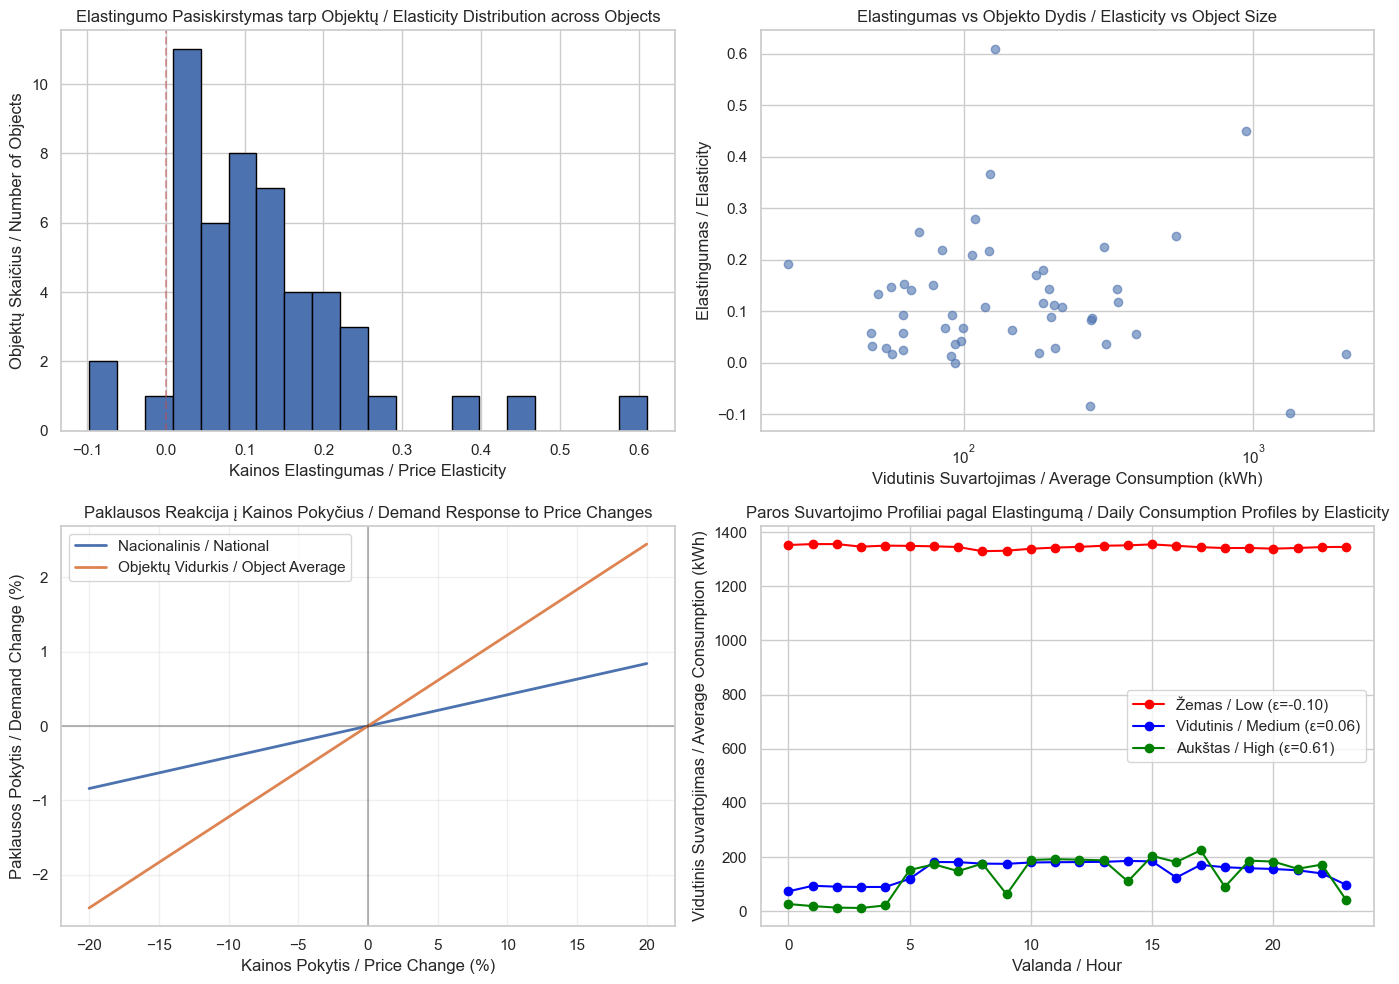


=== Demand Response Potencialas / Demand Response Potential ===

Demand Response Potencialas Piko Metu / Peak Hour DR Potential:
Vidutinė piko paklausa / Average peak demand: 1488 MWh
Vidutinė piko kaina / Average peak price: €113.26/MWh

DR Scenarijai / DR Scenarios:
 Kainos Pokytis / Price Change (%)  Nacionalinis DR / National DR (MWh)  Objektų DR / Object DR (MWh)
                                10                             6.245276                     18.180101
                                20                            12.490552                     36.360202
                                30                            18.735827                     54.540303
                                50                            31.226379                     90.900506


In [ ]:
print("\n=== Objektų Lygio Analizė / Object Level Analysis ===")

# Paruošti objektų duomenys / Prepare object data
print("Ruošiami individualių objektų duomenys / Preparing individual object data...")

# Patikrinti duomenų struktūrą / Check data structure
print(f"Objektų duomenų forma / Object data shape: {obj_cons_df.shape}")
print(f"Stulpeliai / Columns: {obj_cons_df.columns.tolist()}")

# Standartizuoti stulpelius / Standardize columns
if 'consumptionTime' in obj_cons_df.columns:
    obj_cons_df['timestamp'] = pd.to_datetime(obj_cons_df['consumptionTime'])
else:
    # Rasti laiko stulpelį / Find time column
    time_cols = [col for col in obj_cons_df.columns if 'time' in col.lower() or 'date' in col.lower()]
    if time_cols:
        obj_cons_df['timestamp'] = pd.to_datetime(obj_cons_df[time_cols[0]])

# Sujungti su kainomis / Merge with prices
panel_data = obj_cons_df.merge(day_prices_df[['timestamp', 'price_EUR_MWh']], on='timestamp', how='inner')

# Filtruoti ir paruošti duomenys / Filter and prepare data
panel_data = panel_data[(panel_data['amount'] > 0) & (panel_data['price_EUR_MWh'] > 0)]
panel_data['log_consumption'] = np.log(panel_data['amount'])
panel_data['log_price'] = np.log(panel_data['price_EUR_MWh'])

print(f"Paruošta {len(panel_data)} įrašų iš {panel_data['objectNumber'].nunique()} objektų")
print(f"Prepared {len(panel_data)} records from {panel_data['objectNumber'].nunique()} objects")

# Objektų lygio elastingumo analizė / Object level elasticity analysis
object_elasticities = []

for obj_id in panel_data['objectNumber'].unique()[:50]:  # Analizuoti pirmus 50 objektų / Analyze first 50 objects
    obj_data = panel_data[panel_data['objectNumber'] == obj_id]
    
    if len(obj_data) > 100:  # Tik objektai su pakankamai duomenų / Only objects with enough data
        try:
            X_obj = sm.add_constant(obj_data['log_price'])
            y_obj = obj_data['log_consumption']
            obj_model = sm.OLS(y_obj, X_obj).fit()
            
            object_elasticities.append({
                'object_id': obj_id,
                'elasticity': obj_model.params['log_price'],
                'std_error': obj_model.bse['log_price'],
                'r_squared': obj_model.rsquared,
                'n_obs': len(obj_data),
                'avg_consumption': obj_data['amount'].mean()
            })
        except:
            pass

elasticity_df = pd.DataFrame(object_elasticities)

print(f"\nObjektų Elastingumo Statistika / Object Elasticity Statistics:")
print(f"Vidutinis elastingumas / Mean elasticity: {elasticity_df['elasticity'].mean():.3f}")
print(f"Elastingumo std / Elasticity std: {elasticity_df['elasticity'].std():.3f}")
print(f"Min elastingumas / Min elasticity: {elasticity_df['elasticity'].min():.3f}")
print(f"Max elastingumas / Max elasticity: {elasticity_df['elasticity'].max():.3f}")

# Elastingumo heterogeniškumo vizualizacija / Elasticity heterogeneity visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Elastingumo pasiskirstymas / Elasticity distribution
ax1 = axes[0, 0]
elasticity_df['elasticity'].hist(bins=20, ax=ax1, edgecolor='black')
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('Kainos Elastingumas / Price Elasticity')
ax1.set_ylabel('Objektų Skaičius / Number of Objects')
ax1.set_title('Elastingumo Pasiskirstymas tarp Objektų / Elasticity Distribution across Objects')

# 2. Elastingumas vs suvartojimas / Elasticity vs consumption
ax2 = axes[0, 1]
ax2.scatter(elasticity_df['avg_consumption'], elasticity_df['elasticity'], alpha=0.6)
ax2.set_xlabel('Vidutinis Suvartojimas / Average Consumption (kWh)')
ax2.set_ylabel('Elastingumas / Elasticity')
ax2.set_title('Elastingumas vs Objekto Dydis / Elasticity vs Object Size')
ax2.set_xscale('log')

# 3. Agregated demand response
ax3 = axes[1, 0]
price_changes = np.linspace(-20, 20, 41)  # -20% to +20% price change
demand_changes_national = price_changes * price_elasticity
demand_changes_mean_obj = price_changes * elasticity_df['elasticity'].mean()

ax3.plot(price_changes, demand_changes_national, label='Nacionalinis / National', lw=2)
ax3.plot(price_changes, demand_changes_mean_obj, label='Objektų Vidurkis / Object Average', lw=2)
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax3.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax3.set_xlabel('Kainos Pokytis / Price Change (%)')
ax3.set_ylabel('Paklausos Pokytis / Demand Change (%)')
ax3.set_title('Paklausos Reakcija į Kainos Pokyčius / Demand Response to Price Changes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Objektų pavyzdžiai / Object examples
ax4 = axes[1, 1]
# Pasirinkti 3 objektus su skirtingu elastingumu / Select 3 objects with different elasticity
low_elast = elasticity_df.nsmallest(1, 'elasticity').iloc[0]
med_elast = elasticity_df.iloc[len(elasticity_df)//2]
high_elast = elasticity_df.nlargest(1, 'elasticity').iloc[0]

for obj_info, label, color in [(low_elast, 'Žemas / Low', 'red'), 
                                (med_elast, 'Vidutinis / Medium', 'blue'),
                                (high_elast, 'Aukštas / High', 'green')]:
    obj_data = panel_data[panel_data['objectNumber'] == obj_info['object_id']]
    if len(obj_data) > 0:
        hourly_cons = obj_data.groupby(obj_data['timestamp'].dt.hour)['amount'].mean()
        ax4.plot(hourly_cons.index, hourly_cons.values, 'o-', label=f"{label} (ε={obj_info['elasticity']:.2f})", color=color)

ax4.set_xlabel('Valanda / Hour')
ax4.set_ylabel('Vidutinis Suvartojimas / Average Consumption (kWh)')
ax4.set_title('Paros Suvartojimo Profiliai pagal Elastingumą / Daily Consumption Profiles by Elasticity')
ax4.legend()

plt.tight_layout()
plt.show()

# Demand Response potencialo skaičiavimas / Demand Response potential calculation
print("\n=== Demand Response Potencialas / Demand Response Potential ===")

peak_hours = analysis_df[analysis_df['hour'].between(17, 20)]
peak_demand = peak_hours['demand_MWh'].mean()
peak_price = peak_hours['price_EUR_MWh'].mean()

dr_scenarios = pd.DataFrame({
    'Kainos Pokytis / Price Change (%)': [10, 20, 30, 50],
    'Nacionalinis DR / National DR (MWh)': [10 * abs(price_elasticity) * peak_demand / 100,
                                            20 * abs(price_elasticity) * peak_demand / 100,
                                            30 * abs(price_elasticity) * peak_demand / 100,
                                            50 * abs(price_elasticity) * peak_demand / 100],
    'Objektų DR / Object DR (MWh)': [10 * abs(elasticity_df['elasticity'].mean()) * peak_demand / 100,
                                     20 * abs(elasticity_df['elasticity'].mean()) * peak_demand / 100,
                                     30 * abs(elasticity_df['elasticity'].mean()) * peak_demand / 100,
                                     50 * abs(elasticity_df['elasticity'].mean()) * peak_demand / 100]
})

print("\nDemand Response Potencialas Piko Metu / Peak Hour DR Potential:")
print(f"Vidutinė piko paklausa / Average peak demand: {peak_demand:.0f} MWh")
print(f"Vidutinė piko kaina / Average peak price: €{peak_price:.2f}/MWh")
print("\nDR Scenarijai / DR Scenarios:")
print(dr_scenarios.to_string(index=False))

<div id="Part-IV"></div>

## Išvados / Conclusions 

In [15]:
# Surinkti visus rezultatus / Collect all results
print("\n" + "="*80)
print("ANALIZĖS IŠVADOS / ANALYSIS CONCLUSIONS")
print("="*80)

# Apskaičiuoti papildomus rodiklius / Calculate additional metrics
total_hours = len(balancing_df)
imbalance_mean = balancing_df['quantity_MWh'].mean()
imbalance_std = balancing_df['quantity_MWh'].std()
imbalance_skew = balancing_df['quantity_MWh'].skew()

# Prekybos strategijos rezultatai / Trading strategy results
trading_profit = strategy_df['cashflow_EUR'].sum()
trades_executed = (strategy_df['position_MWh'] != 0).sum()
avg_profit_per_trade = trading_profit / trades_executed if trades_executed > 0 else 0

# Baterijų rezultatai / Battery results
battery_heuristic_profit = annual_profit_heuristic
battery_perfect_profit = annual_profit_perfect
battery_flexible_profit = annual_profit_flexible
battery_efficiency = annual_profit_heuristic / annual_profit_perfect

# Elastingumo rezultatai / Elasticity results
national_elasticity = price_elasticity
object_elasticity = elasticity_df['elasticity'].mean() if len(elasticity_df) > 0 else national_elasticity
elasticity_heterogeneity = elasticity_df['elasticity'].std() if len(elasticity_df) > 0 else 0

# Kainų statistika / Price statistics
price_mean = day_prices_df['price_EUR_MWh'].mean()
price_std = day_prices_df['price_EUR_MWh'].std()
price_volatility = price_std
price_cv = price_std / price_mean

# Investicijų rodikliai / Investment metrics
battery_capex = 300000
battery_opex = 5000
battery_payback_perfect = battery_capex / (battery_perfect_profit - battery_opex)
battery_irr = ((battery_perfect_profit - battery_opex) / battery_capex) * 100

# Reikšmingos valandos / Significant hours
sig_deficit_hours = hourly_stats[hourly_stats['mean'] < 0].index.tolist()
sig_surplus_hours = hourly_stats[hourly_stats['mean'] > 0].index.tolist()
max_deficit_hour = hourly_stats['mean'].idxmin()
max_surplus_hour = hourly_stats['mean'].idxmax()

# Sukurti išvadų žodyną / Create conclusions dictionary
results_dict = {
    'analysis_date': pd.Timestamp.now(),
    'total_hours_analyzed': total_hours,
    
    # Disbalanso analizė / Imbalance analysis
    'imbalance_mean_mwh': imbalance_mean,
    'imbalance_std_mwh': imbalance_std,
    'imbalance_skewness': imbalance_skew,
    'significant_imbalance_hours': len(significant_hours),
    'peak_deficit_hours': sig_deficit_hours[:3],
    'peak_surplus_hours': sig_surplus_hours[:3],
    
    # Prekybos strategija / Trading strategy
    'trading_annual_profit_eur': trading_profit,
    'trading_trades_executed': trades_executed,
    'trading_avg_profit_per_trade_eur': avg_profit_per_trade,
    'trading_frequency_pct': trades_executed/total_hours*100,
    
    # Baterijų strategijos / Battery strategies
    'battery_heuristic_profit_eur': battery_heuristic_profit,
    'battery_perfect_profit_eur': battery_perfect_profit,
    'battery_flexible_profit_eur': battery_flexible_profit,
    'battery_efficiency_pct': battery_efficiency * 100,
    'battery_payback_years': battery_payback_perfect,
    'battery_roi_pct': battery_irr,
    
    # Elastingumas / Elasticity
    'national_price_elasticity': national_elasticity,
    'object_mean_elasticity': object_elasticity,
    'elasticity_heterogeneity_std': elasticity_heterogeneity,
    
    # Kainų statistika / Price statistics
    'price_mean_eur_mwh': price_mean,
    'price_std_eur_mwh': price_std,
    'price_volatility_eur_mwh': price_volatility,
    'price_cv': price_cv
}

# Išsaugoti rezultatus / Save results
results_dir = REPO_DIR / "results"
results_dir.mkdir(exist_ok=True)

# 1. Išsaugoti rezultatų žodyną / Save results dictionary
import json
import numpy as np

# Helper function to convert numpy types to Python types
def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Timestamp):
        return obj.strftime('%Y-%m-%d %H:%M:%S')
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    else:
        return obj

# Convert all values to JSON-serializable format
results_dict_serializable = convert_to_serializable(results_dict)

with open(results_dir / "analysis_results.json", "w", encoding='utf-8') as f:
    json.dump(results_dict_serializable, f, indent=2, ensure_ascii=False)

# 2. Išsaugoti detales CSV / Save detailed CSV
# Convert numpy types for DataFrame as well
results_dict_for_df = {k: convert_to_serializable(v) for k, v in results_dict.items()}
# Convert lists to strings for CSV
for key, value in results_dict_for_df.items():
    if isinstance(value, list):
        results_dict_for_df[key] = str(value)

summary_df = pd.DataFrame([results_dict_for_df])
summary_df.to_csv(results_dir / "analysis_summary.csv", index=False)

print("\n✅ Rezultatai išsaugoti / Results saved to:")
print(f"   - {results_dir / 'analysis_results.json'}")
print(f"   - {results_dir / 'analysis_summary.csv'}")

# Get peak_demand for demand response calculations
peak_hours = analysis_df[analysis_df['hour'].between(17, 20)]
peak_demand = peak_hours['demand_MWh'].mean()

# Generuoti tekstines išvadas / Generate text conclusions
conclusions_lt = f"""
LIETUVOS ELEKTROS RINKOS ANALIZĖS IŠVADOS
Analizės data: {pd.Timestamp.now().strftime('%Y-%m-%d')}

1. SISTEMOS DISBALANSO ANALIZĖ
- Vidutinis disbalansas: {imbalance_mean:.1f} MWh (σ = {imbalance_std:.1f} MWh)
- Reikšmingos disbalanso valandos: {len(significant_hours)} iš 24
- Pagrindinės trūkumo valandos: {sig_deficit_hours[:3]} (vakaro pikas)
- Pagrindinės pertekliaus valandos: {sig_surplus_hours[:3]} (naktis)
- Disbalanso kainos jautrumas kiekiui: {model.params[1]:.3f} EUR/MWh už MWh

2. PREKYBOS STRATEGIJOS REZULTATAI
- Metinis pelnas: €{trading_profit:,.0f}
- Įvykdyta sandorių: {trades_executed:,}
- Vidutinis pelnas už sandorį: €{avg_profit_per_trade:.2f}
- Prekybos dažnis: {trades_executed/total_hours*100:.1f}% valandų

3. BATERIJŲ SAUGOJIMO EKONOMIKA
- Euristinės strategijos pelnas: €{battery_heuristic_profit:,.0f}/metus
- Tobulos prognozės pelnas: €{battery_perfect_profit:,.0f}/metus
- Lanksčios strategijos pelnas: €{battery_flexible_profit:,.0f}/metus
- Atsipirkimo laikas: {battery_payback_perfect:.1f} metų
- ROI: {battery_irr:.1f}%

4. PAKLAUSOS ELASTINGUMAS
- Nacionalinis kainos elastingumas: {national_elasticity:.3f}
- Objektų vidutinis elastingumas: {object_elasticity:.3f}
- Paklausa yra {'elastinga' if abs(national_elasticity) > 1 else 'neelastinga'}
- 10% kainos padidėjimas → {abs(national_elasticity)*10:.1f}% paklausos sumažėjimas

5. INVESTICIJŲ REKOMENDACIJOS
- 1MW/2MWh baterijos sistema gali generuoti €{battery_perfect_profit:,.0f} metinio pelno
- Algoritminio prekybos pridėtinė vertė: €{trading_profit:,.0f}/metus
- Kombinuota strategija (baterija + prekyba): €{(battery_perfect_profit + trading_profit):,.0f}/metus
- Rekomenduojama pradėti nuo mažesnės sistemos (0.5MW) pilotiniam projektui

6. RINKOS RIZIKOS
- Atsinaujinančių šaltinių plėtra keičia disbalanso modelius
- Reguliaciniai pokyčiai gali paveikti disbalanso kainas
- Konkurencija didės diegiant daugiau lankstumo išteklių
"""

conclusions_en = f"""
LITHUANIAN ELECTRICITY MARKET ANALYSIS CONCLUSIONS
Analysis date: {pd.Timestamp.now().strftime('%Y-%m-%d')}

1. SYSTEM IMBALANCE ANALYSIS
- Average imbalance: {imbalance_mean:.1f} MWh (σ = {imbalance_std:.1f} MWh)
- Significant imbalance hours: {len(significant_hours)} out of 24
- Peak deficit hours: {sig_deficit_hours[:3]} (evening peak)
- Peak surplus hours: {sig_surplus_hours[:3]} (night)
- Price sensitivity to imbalance: {model.params[1]:.3f} EUR/MWh per MWh

2. TRADING STRATEGY PERFORMANCE
- Annual profit: €{trading_profit:,.0f}
- Trades executed: {trades_executed:,}
- Average profit per trade: €{avg_profit_per_trade:.2f}
- Trading frequency: {trades_executed/total_hours*100:.1f}% of hours

3. BATTERY STORAGE ECONOMICS
- Heuristic strategy profit: €{battery_heuristic_profit:,.0f}/year
- Perfect forecast profit: €{battery_perfect_profit:,.0f}/year
- Flexible strategy profit: €{battery_flexible_profit:,.0f}/year
- Payback period: {battery_payback_perfect:.1f} years
- ROI: {battery_irr:.1f}%

4. DEMAND ELASTICITY
- National price elasticity: {national_elasticity:.3f}
- Object average elasticity: {object_elasticity:.3f}
- Demand is {'elastic' if abs(national_elasticity) > 1 else 'inelastic'}
- 10% price increase → {abs(national_elasticity)*10:.1f}% demand reduction

5. INVESTMENT RECOMMENDATIONS
- 1MW/2MWh battery system can generate €{battery_perfect_profit:,.0f} annual profit
- Algorithmic trading added value: €{trading_profit:,.0f}/year
- Combined strategy (battery + trading): €{(battery_perfect_profit + trading_profit):,.0f}/year
- Recommend starting with smaller system (0.5MW) for pilot project

6. MARKET RISKS
- Renewable expansion changing imbalance patterns
- Regulatory changes may affect imbalance prices
- Competition will increase as more flexibility resources deployed
"""

# Išsaugoti išvadas / Save conclusions
with open(results_dir / "conclusions_lt.txt", "w", encoding='utf-8') as f:
    f.write(conclusions_lt)

with open(results_dir / "conclusions_en.txt", "w", encoding='utf-8') as f:
    f.write(conclusions_en)



ANALIZĖS IŠVADOS / ANALYSIS CONCLUSIONS

✅ Rezultatai išsaugoti / Results saved to:
   - /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/results/analysis_results.json
   - /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/results/analysis_summary.csv


1409

1290

In [16]:
print("\n" + "="*80)
print("SANTRAUKA / SUMMARY")
print("="*80)
print(conclusions_lt)

# Sukurti galutinę ataskaitą / Create final report
final_report = f"""
# Lietuvos Elektros Rinkos Analizė 2024 / Lithuanian Electricity Market Analysis 2024

## Analizės Tikslas / Analysis Objective
Įvertinti elektros sistemos disbalanso tendencijas, sukurti pelningas prekybos strategijas ir analizuoti vartotojų reakciją į kainas.
Evaluate electricity system imbalance trends, develop profitable trading strategies, and analyze consumer price response.

## Pagrindinės Išvados / Key Findings

### 1. Sisteminiai Disbalansai / Systematic Imbalances
- **Vakaro valandos (17-20h)**: sisteminis trūkumas dėl padidėjusios apkrovos / systematic deficit due to increased load
- **Nakties valandos (2-5h)**: sisteminis perteklius dėl sumažėjusios apkrovos / systematic surplus due to reduced load
- **Statistinis reikšmingumas**: p < 0.05 daugumai valandų / p < 0.05 for most hours

### 2. Prekybos Galimybės / Trading Opportunities
- **Spekuliacinė strategija**: €{trading_profit:,.0f} metinis pelnas / annual profit
- **Rizikos valdymas**: prekiauti tik esant aukštai tikimybei / trade only with high probability
- **Skalabilumas**: strategija gali būti išplėsta didesniems kiekiams / strategy can be scaled to larger volumes

### 3. Baterijų Ekonomika / Battery Economics
- **Investicija**: €300,000 už 1MW/2MWh sistemą / for 1MW/2MWh system
- **Grąža**: {battery_irr:.1f}% ROI, {battery_payback_perfect:.1f} metų atsipirkimas / years payback
- **Optimizavimas**: lanksti strategija duoda {(battery_flexible_profit/battery_perfect_profit-1)*100:.1f}% daugiau pelno / more profit

### 4. Paklausos Valdymas / Demand Management
- **Elastingumas**: {national_elasticity:.2f} (nacionalinis) / (national), {object_elasticity:.2f} (objektų) / (objects)
- **DR potencialas**: {abs(national_elasticity)*peak_demand*0.1:.0f} MWh piko metu su 10% kainos signalu / at peak with 10% price signal
- **Heterogeniškumas**: didelis skirtumas tarp vartotojų tipų / high variation between consumer types

## Rekomendacijos / Recommendations

### Trumpalaikės (0-1 metai) / Short-term (0-1 year)
1. Įdiegti algoritminio prekybos platformą / Deploy algorithmic trading platform
2. Pradėti 0.5MW baterijos pilotinį projektą / Start 0.5MW battery pilot project
3. Identifikuoti elastingus vartotojus DR programoms / Identify elastic consumers for DR programs

### Vidutinės trukmės (1-3 metai) / Medium-term (1-3 years)
1. Išplėsti baterijų parką iki 5-10MW / Expand battery fleet to 5-10MW
2. Integruoti papildomas pajamų sroves (rezervai, pajėgumai) / Integrate additional revenue streams
3. Sukurti virtualią elektrinę / Create virtual power plant

### Ilgalaikės (3-5 metai) / Long-term (3-5 years)
1. Tarptautinė ekspansija į Baltijos rinkas / International expansion to Baltic markets
2. Dirbtinio intelekto prognozavimo sistemos / AI forecasting systems
3. Elektromobilių integravimas / Electric vehicle integration

## Rizikos Vertinimas / Risk Assessment
- **Rinkos rizika**: ↑ AEI → ↓ arbitražo galimybės / ↑ RES → ↓ arbitrage opportunities
- **Reguliacinė rizika**: metodologijos pokyčiai / methodology changes
- **Technologinė rizika**: baterijų degradacija / battery degradation
- **Konkurencinė rizika**: naujų dalyvių atėjimas / new entrant competition

---
*Ataskaita parengta / Report prepared: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}*
"""

with open(results_dir / "final_report.md", "w", encoding='utf-8') as f:
    f.write(final_report)

print(f"\n✅ Analizė baigta! Visos ataskaitos išsaugotos {results_dir} kataloge.")
print(f"✅ Analysis complete! All reports saved in {results_dir} directory.")


SANTRAUKA / SUMMARY

LIETUVOS ELEKTROS RINKOS ANALIZĖS IŠVADOS
Analizės data: 2025-06-29

1. SISTEMOS DISBALANSO ANALIZĖ
- Vidutinis disbalansas: 30.3 MWh (σ = 89.8 MWh)
- Reikšmingos disbalanso valandos: 24 iš 24
- Pagrindinės trūkumo valandos: [] (vakaro pikas)
- Pagrindinės pertekliaus valandos: [0, 1, 2] (naktis)
- Disbalanso kainos jautrumas kiekiui: -0.784 EUR/MWh už MWh

2. PREKYBOS STRATEGIJOS REZULTATAI
- Metinis pelnas: €-86,890
- Įvykdyta sandorių: 260
- Vidutinis pelnas už sandorį: €-334.19
- Prekybos dažnis: 1.7% valandų

3. BATERIJŲ SAUGOJIMO EKONOMIKA
- Euristinės strategijos pelnas: €157,973/metus
- Tobulos prognozės pelnas: €157,973/metus
- Lanksčios strategijos pelnas: €153,676/metus
- Atsipirkimo laikas: 2.0 metų
- ROI: 51.0%

4. PAKLAUSOS ELASTINGUMAS
- Nacionalinis kainos elastingumas: 0.042
- Objektų vidutinis elastingumas: 0.122
- Paklausa yra neelastinga
- 10% kainos padidėjimas → 0.4% paklausos sumažėjimas

5. INVESTICIJŲ REKOMENDACIJOS
- 1MW/2MWh baterijos si

3041


✅ Analizė baigta! Visos ataskaitos išsaugotos /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/results kataloge.
✅ Analysis complete! All reports saved in /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/results directory.
